# Price Analysis New


In [18]:
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
#I want to plot output price vs release date
import matplotlib.pyplot as plt

#read in csv file and convert to pandas dataframe
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression, QuantileRegressor



In [19]:

# df = pd.read_csv('datasets/art_analysis_scrape.csv')

# #print the first 5 rows of the dataframe
# # print(df.head())
# print(df.columns)

# # Convert 'release_date' to datetime if it's not already
# #filter out nan values  

# #filter based on 
# df = df[df['Output Price\nUSD/1M Tokens'].notna()]
# df = df[df['Release Date'].notna()]
# df['Release Date'] = pd.to_datetime(df['Release Date'])

# # Convert price to float - handle the case where it might not be a string
# # First check if the column contains strings





# if df['Output Price\nUSD/1M Tokens'].dtype == 'object':
#     df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# else:
#     # If it's already numeric, just ensure it's float type
#     df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].astype(float)

# #clean up data related to lowest price found 




# #make a column of called active parameters if Know active parameters is available use that, otherwise use params
# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
# df['Active Parameters'] = np.where(
#     df['Known Active Parameters'].notna(),
#     df['Known Active Parameters'],
#     df['Parameters']
# )




# #collect output price for models with open licenses
# open_license_df = df[df['License'] == 'Open']
# proprietary_df = df[df['License'] == 'Proprietary']

# Data Processing

In [20]:

df = pd.read_csv('price_reduction_models.csv')
print(df.columns)
#convert price to float
# df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
# df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


#convert release date to datetime where release date is not nan
df['Release Date'] = pd.to_datetime(df['Release Date'])



# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)

#print the first 5 rows of the datafr

Index(['Model', 'Creator', 'License', 'Context\n Window',
       'Artificial Analysis\n Intelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\n USD/1M Tokens', 'Median\n Tokens/s', 'P5\n Tokens/s',
       'P25\n Tokens/s', 'P75\n Tokens/s', 'P95\n Tokens/s',
       'Median\n First Chunk (s)', 'First Answer\n Token (s)',
       'P5\n First Chunk (s)', 'P25\n First Chunk (s)',
       'P75\n First Chunk (s)', 'P95\n First Chunk (s)',
       'Total\n Response (s)', 'Reasoning\n Time (s)', 'Reasoning_TF',
       'Further\n Analysis', 'Release Date', 'Parameters',
       'Known Active Parameters', 'Latency', 'token/s', 'Chinese', 'Notes',
       'input

In [5]:
# I Want to see which of these columns has the most non-na values
# cols = ['MMLU-Pro (Reasoning & Knowledge)','GPQA Diamond (Scientific Reasoning)', "Humanity's Last Exam (Reasoning & Knowledge)", 'LiveCodeBench (Coding)','MATH-500 (Quantitative Reasoning)', 'HumanEval (Coding)', 'SciCode (Coding)']

# list of columns you care about
cols = [
    'MMLU-Pro (Reasoning & Knowledge)',
    'GPQA Diamond (Scientific Reasoning)',
    "Humanity's Last Exam (Reasoning & Knowledge)",
    'LiveCodeBench (Coding)',
    'MATH-500 (Quantitative Reasoning)',
    'HumanEval (Coding)',
    'SciCode (Coding)'
]

# Count the non-NA entries column-by-column
non_na_counts = df[cols].notna().sum()

# Sort so the “best” column is first
non_na_counts = non_na_counts.sort_values(ascending=False)

print(non_na_counts)                 # full ranking
print()                              
print("Column with the most non-NA values:")
print(f"{non_na_counts.idxmax()}  →  {non_na_counts.max()} rows")

MMLU-Pro (Reasoning & Knowledge)                25
GPQA Diamond (Scientific Reasoning)             25
Humanity's Last Exam (Reasoning & Knowledge)    25
LiveCodeBench (Coding)                          25
MATH-500 (Quantitative Reasoning)               25
SciCode (Coding)                                25
HumanEval (Coding)                              19
dtype: int64

Column with the most non-NA values:
MMLU-Pro (Reasoning & Knowledge)  →  25 rows


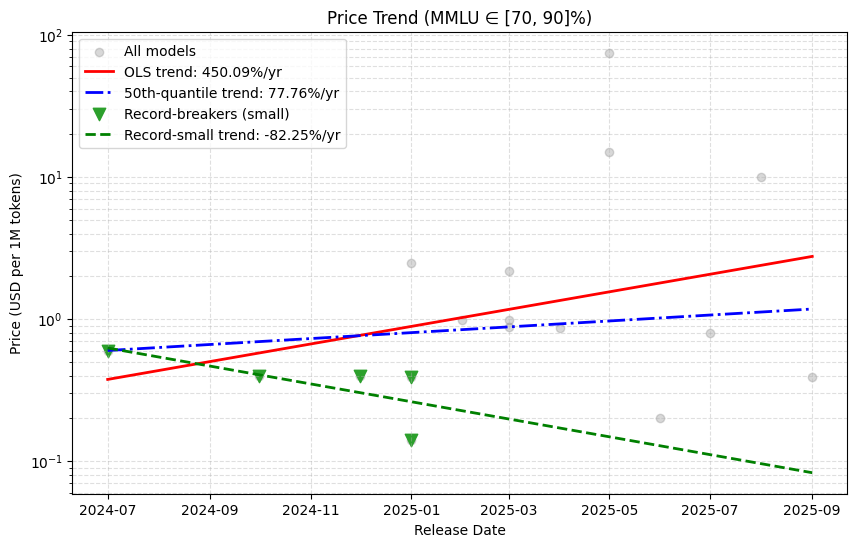

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from datetime import datetime

# 0) Bounds & column names
min_mmlu = 70
max_mmlu = 90
mmlu_col = 'MMLU-Pro (Reasoning & Knowledge)'
price_col = 'Output Price\nUSD/1M Tokens'

# 1) Convert MMLU “XX%” → float
df[mmlu_col] = (
    df[mmlu_col].astype(str)
                .str.replace('%','',regex=False)
                .astype(float)
)

# 2) Convert price “$X,XXX” → float
df[price_col] = (
    df[price_col].astype(str)
                 .str.replace('[$,]','',regex=True)
)
df[price_col] = pd.to_numeric(df[price_col], errors='coerce')

# 3) Filter to MMLU range & drop missing
df_sub = df[df[mmlu_col].between(min_mmlu, max_mmlu)].copy()
df_sub = df_sub.dropna(subset=['Release Date', price_col])

# 4) Remove non-positive prices to avoid -inf in log10
df_sub = df_sub[df_sub[price_col] > 0]

# 5) Sort by Release Date & compute ordinal
df_sub = df_sub.sort_values('Release Date')
df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

# 6) Prepare X, y_log
X = df_sub['Date_Ordinal'].values.reshape(-1, 1)
y_log = np.log10(df_sub[price_col].values)

# 7) Fit overall OLS on log(price)
model_all = LinearRegression().fit(X, y_log)

# 8) Fit median (τ=0.5) Quantile Regression on log(price)
quantile = 0.5
qr = QuantileRegressor(quantile=quantile, alpha=0.0).fit(X, y_log)

# 9) Build daily grid for predictions
min_ord = df_sub['Date_Ordinal'].min()
max_ord = df_sub['Date_Ordinal'].max()
x_range = np.arange(min_ord, max_ord + 1)
x_dates = [datetime.fromordinal(int(d)) for d in x_range]

y_ols_log = model_all.predict(x_range.reshape(-1,1))
y_qr_log  = qr.predict(x_range.reshape(-1,1))

# 10) Compute annualized % growth
coef_ols     = model_all.coef_[0]
annual_pct_ols = ((10**coef_ols)**365 - 1) * 100
coef_qr      = qr.coef_[0]
annual_pct_qr  = ((10**coef_qr)**365 - 1) * 100

# 11) Identify “record‐breaking small” (running minima of price)
df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
record_small = df_sub[df_sub['Is_Record_Small']].copy()

# 12) Fit OLS on the record‐small points
X_rec      = record_small['Date_Ordinal'].values.reshape(-1,1)
y_rec_log  = np.log10(record_small[price_col].values)
model_rec  = LinearRegression().fit(X_rec, y_rec_log)
y_rec_log_pred = model_rec.predict(x_range.reshape(-1,1))
coef_rec    = model_rec.coef_[0]
annual_pct_rec = ((10**coef_rec)**365 - 1) * 100

# 13) Plot everything
plt.figure(figsize=(10,6))

# a) All points
plt.scatter(
    df_sub['Release Date'], df_sub[price_col],
    color='gray', alpha=0.3, label='All models'
)

# b) Overall OLS trend
plt.plot(
    x_dates, 10**y_ols_log,
    'r-', lw=2,
    label=f'OLS trend: {annual_pct_ols:.2f}%/yr'
)

# c) Median quantile trend
plt.plot(
    x_dates, 10**y_qr_log,
    'b-.', lw=2,
    label=f'{quantile*100:.0f}th-quantile trend: {annual_pct_qr:.2f}%/yr'
)

# d) Record‐small points
plt.scatter(
    record_small['Release Date'], record_small[price_col],
    color='tab:green', s=80, marker='v',
    label='Record-breakers (small)'
)

# e) Record‐small OLS trend
plt.plot(
    x_dates, 10**y_rec_log_pred,
    'g--', lw=2,
    label=f'Record-small trend: {annual_pct_rec:.2f}%/yr'
)

plt.yscale('log')
plt.xlabel('Release Date')
plt.ylabel('Price (USD per 1M tokens)')
plt.title(f'Price Trend (MMLU ∈ [{min_mmlu}, {max_mmlu}]%)')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.legend()
plt.show()

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from datetime import datetime
from scipy import stats

def plot_price_trend_by_mmlu(min_mmlu, max_mmlu, open_license_only=False, quantile=0.2, price_col='Output Price\nUSD/1M Tokens', show_model_names=False, show_confidence_interval=False):
    """
    Plot price‐per‐1M-token trends for models with MMLU in [min_mmlu, max_mmlu].
    If open_license_only=True, only keep rows where `license_col` contains 'open' (case‐insensitive).
    Assumes `df` is in scope with columns:
      - 'Release Date' (datetime64)
      - 'MMLU-Pro (Reasoning & Knowledge)' (e.g. "75%")
      - price_col (e.g. "$0.50")
      - license_col (e.g. 'License')
    
    Parameters:
      min_mmlu: Minimum MMLU score to include
      max_mmlu: Maximum MMLU score to include
      open_license_only: If True, only include models with open licenses
      quantile: Quantile level for the quantile regression (default: 0.5 for median)
      price_col: Column name for price data (default: 'Output Price\nUSD/1M Tokens')
      show_model_names: If True, displays model names next to record-small points
      show_confidence_interval: If True, shows 90% confidence interval for record-small trend
    """
    # --- column names ---
    mmlu_col    = 'MMLU-Pro (Reasoning & Knowledge)'
    license_col = 'License'   # ← adjust if your CSV uses a different header

    # 1) Work on a copy
    df_work = df.copy()

    # 2) Convert MMLU "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%','',regex=False)
                         .astype(float)
    )

    # 3) Convert price "$X,XXX" → float
    df_work[price_col] = (
        df_work[price_col].astype(str)
                         .str.replace('[$,]','',regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

    # 4) Optionally filter to open‐license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 5) Filter to MMLU range
    df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

    # 6) Drop missing Release Date or price, remove non‐positive prices
    df_sub = df_sub.dropna(subset=['Release Date', price_col])
    df_sub = df_sub[df_sub[price_col] > 0]

    # 7) Sort & compute ordinal date
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

    # 8) Prepare regressions on log10(price)
    X     = df_sub['Date_Ordinal'].values.reshape(-1,1)
    y_log = np.log10(df_sub[price_col].values)

    # overall OLS
    ols = LinearRegression().fit(X, y_log)
    # quantile regression with specified quantile
    qr  = QuantileRegressor(quantile=quantile, alpha=0.0).fit(X, y_log)

    # 9) Build daily grid for predictions
    min_ord, max_ord = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range = np.arange(min_ord, max_ord + 1)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]

    y_ols_log = ols.predict(x_range.reshape(-1,1))
    y_qr_log  = qr.predict(x_range.reshape(-1,1))

    # 10) Compute annualized % growth and price decrease factor
    annual_pct_ols = ((10**ols.coef_[0])**365 - 1) * 100
    annual_factor_ols = 1 / (10**ols.coef_[0])**365
    
    annual_pct_qr  = ((10**qr.coef_[0])**365 - 1) * 100
    annual_factor_qr = 1 / (10**qr.coef_[0])**365

    # 11) "Record‐small" = running minima of price
    df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
    record_small = df_sub[df_sub['Is_Record_Small']].copy()

    # OLS on those
    X_rec         = record_small['Date_Ordinal'].values.reshape(-1,1)
    y_rec_log     = np.log10(record_small[price_col].values)
    rec_ols       = LinearRegression().fit(X_rec, y_rec_log)
    y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
    annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
    annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365
    
    # Calculate confidence interval for record-small trend if requested
    ci_text = ""
    if show_confidence_interval and len(X_rec) > 2:
        # Get prediction interval for the coefficient
        n = len(X_rec)
        mean_x = np.mean(X_rec)
        t_val = stats.t.ppf(0.95, n-2)  # 90% CI (two-tailed)
        
        # Standard error calculation
        sum_squared_errors = np.sum((y_rec_log - rec_ols.predict(X_rec))**2)
        sum_squared_x_diff = np.sum((X_rec.flatten() - mean_x)**2)
        std_err = np.sqrt(sum_squared_errors / (n-2) / sum_squared_x_diff)
        
        # Confidence interval for slope
        ci_lower = rec_ols.coef_[0] - t_val * std_err
        ci_upper = rec_ols.coef_[0] + t_val * std_err
        
        # Convert to annual factors
        annual_factor_lower = 1 / (10**ci_lower)**365
        annual_factor_upper = 1 / (10**ci_upper)**365
        
        ci_text = f" (90% CI: {annual_factor_lower:.2f}x-{annual_factor_upper:.2f}x)"

    # 12) Plot
    plt.figure(figsize=(10,6))
    # all
    plt.scatter(df_sub['Release Date'], df_sub[price_col],
                color='gray', alpha=0.3, label='All models')
    # OLS trend
    plt.plot(x_dates, 10**y_ols_log, 'r-', lw=2,
             label=f'OLS trend: {annual_pct_ols:.2f}%/yr ({annual_factor_ols:.2f}x cheaper/yr)')
    # specified quantile
    plt.plot(x_dates, 10**y_qr_log, 'b-.', lw=2,
             label=f'{quantile*100:.0f}th-quantile: {annual_pct_qr:.2f}%/yr ({annual_factor_qr:.2f}x cheaper/yr)')
    # record-small points
    plt.scatter(record_small['Release Date'], record_small[price_col],
                color='tab:green', s=80, marker='v',
                label='Record-small points')
    # record-small trend
    plt.plot(x_dates, 10**y_rec_log_pred, 'g--', lw=2,
             label=f'Record-small trend: {annual_pct_rec:.2f}%/yr ({annual_factor_rec:.2f}x cheaper/yr{ci_text})')
    
    # Add confidence interval bands if requested
    if show_confidence_interval and len(X_rec) > 2:
        # Calculate prediction bands
        y_lower = ci_lower * (x_range - min_ord) + rec_ols.intercept_
        y_upper = ci_upper * (x_range - min_ord) + rec_ols.intercept_
        
        plt.fill_between(x_dates, 10**y_lower, 10**y_upper, 
                         color='green', alpha=0.1, 
                         label='90% CI for record-small trend')
    
    # Add model names if requested
    if show_model_names:
        for idx, row in record_small.iterrows():
            plt.annotate(row['Model'], 
                         (row['Release Date'], row[price_col]),
                         xytext=(5, 5), 
                         textcoords='offset points',
                         fontsize=8)

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Price (USD per 1M tokens)')
    lic_label = 'open‐license only' if open_license_only else 'all licenses'
    plt.title(f'Price Trend (MMLU ∈ [{min_mmlu},{max_mmlu}]%, {lic_label}) \n {price_col}')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend()
    plt.show()

# Example usage:
# plot_price_trend_by_mmlu(50, 70, open_license_only=True, quantile=0.2, show_confidence_interval=True)

# Look At Trend Across All Groups

## Low End Model Group

In [9]:
plot_price_trend_by_mmlu(30, 50, open_license_only=False, quantile=0.2, price_col="Lowest Blended Price AA", show_confidence_interval=True)
plot_price_trend_by_mmlu(10, 30, open_license_only=True, quantile=0.2, price_col="Lowest Blended Price AA", show_model_names=True,show_confidence_interval=True)
# plot_price_trend_by_mmlu(30, 50, open_license_only=True, quantile=0.2)

KeyError: 'Lowest Blended Price AA'

## Medium Level Trend

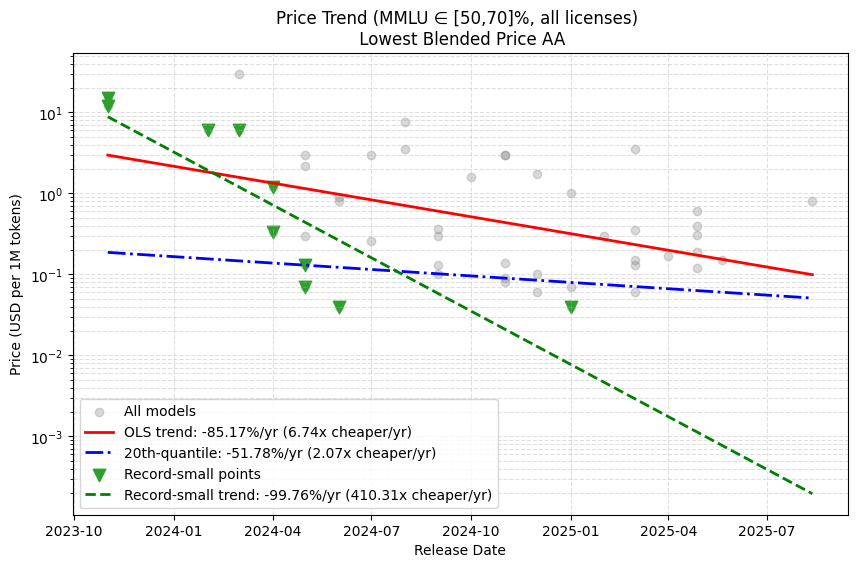

TypeError: plot_price_trend_by_mmlu() got an unexpected keyword argument 'benchmark_col'

In [ ]:
plot_price_trend_by_mmlu(50, 70, open_license_only=False, quantile=0.2, price_col="Lowest Blended Price AA")
plot_price_trend_by_mmlu(20, 30, open_license_only=True, quantile=0.2, price_col="Lowest Output Price Found AA", show_model_names=True, show_confidence_interval=True, benchmark_col="SciCode (Coding)")

## High End Model Group

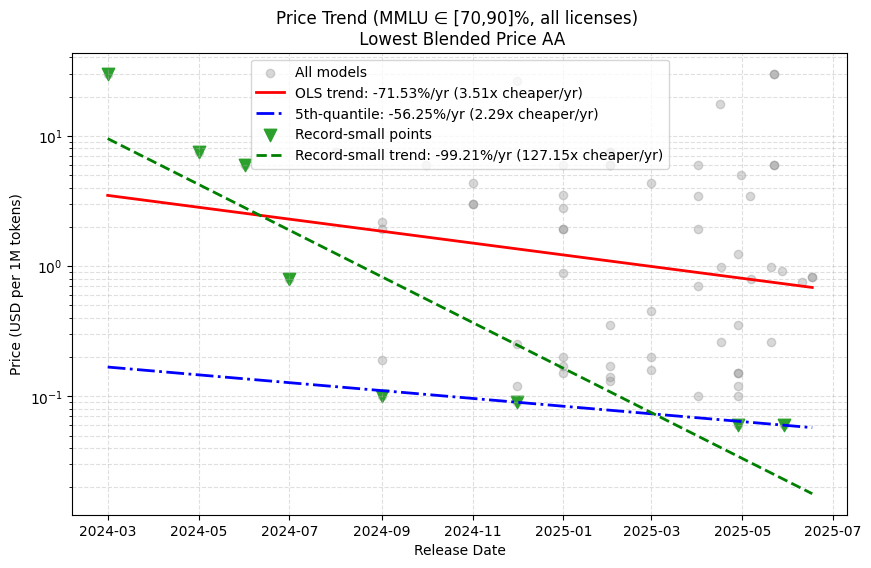

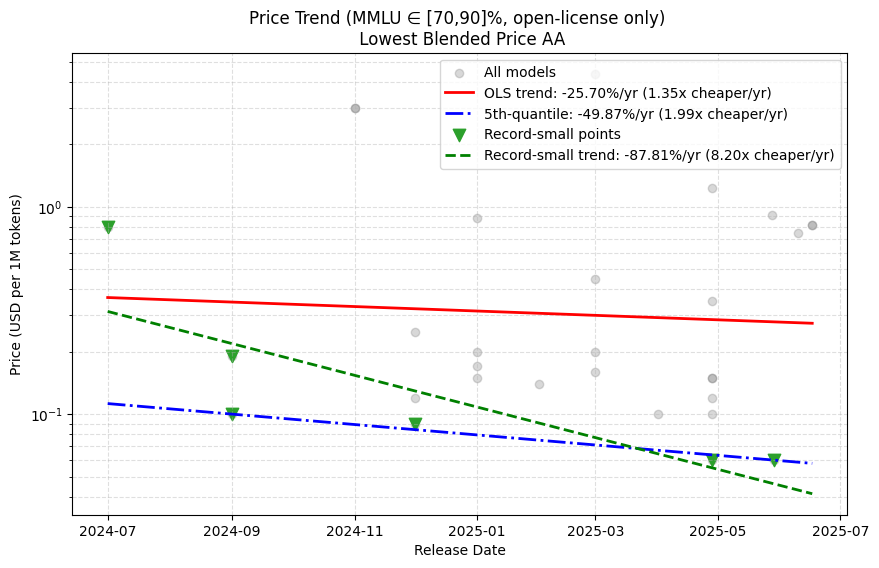

In [ ]:
plot_price_trend_by_mmlu(70, 90, open_license_only=False, quantile=0.05, price_col="Lowest Blended Price AA")
plot_price_trend_by_mmlu(70, 90, open_license_only=True, quantile=0.05, price_col="Lowest Blended Price AA")
# plot_price_trend_by_mmlu(70, 90, open_license_only=True, quantile=0.2)

## Graph Amalgamation

In [ ]:
I want to graph the trend lines for the record small points in each MMLU range ie 30-50, 50-70, 70-90 along with th record small points for each group. The x axis should be release date and the y axis shoudl be price per 1M tokens 

SyntaxError: invalid syntax (645267584.py, line 1)

In [ ]:
# import seaborn as sns
# # Install scienceplots package
# import scienceplots

# sns.set_theme(                              # seaborn upgrades Matplotlib defaults
#     style="whitegrid",                      # five presets: darkgrid | whitegrid | white | dark | ticks
#     context="paper",                        # scales fonts/lines for ~85 mm column width
#     palette="colorblind") 

# def plot_combined_record_small_trends(open_license_only=False, price_col='Lowest Blended Price AA', show_model_names=False):
#     """
#     Plot record-small points and their trend lines for three MMLU ranges (30-50, 50-70, 70-90) 
#     on a single graph.
    
#     Parameters:
#       open_license_only: If True, only include models with open licenses
#       price_col: Column name for price data (default: 'Lowest Blended Price AA')
#       show_model_names: If True, displays model names next to record-small points
#     """

#     plt.style.use(["science", "no-latex"])
#     sns.set_theme(                              # seaborn upgrades Matplotlib defaults
#     style="whitegrid",                      # five presets: darkgrid | whitegrid | white | dark | ticks
#     context="paper",                        # scales fonts/lines for ~85 mm column width
#     palette="colorblind") 
#     # Define MMLU ranges and colors
#     mmlu_ranges = [(30, 50), (50, 70), (70, 90)]
#     colors = ['blue', 'red', 'green']
#     markers = ['o', 's', '^']
    
#     # --- column names ---
#     mmlu_col = 'MMLU-Pro (Reasoning & Knowledge)'
#     license_col = 'License'
    
#     plt.figure(figsize=(12, 8))
    
#     # Store all data for setting axis limits
#     all_dates = []
#     all_prices = []
    
#     for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
#         color = colors[i]
#         marker = markers[i]
        
#         # 1) Work on a copy
#         df_work = df.copy()

#         # 2) Convert MMLU "XX%" → float
#         df_work[mmlu_col] = (
#             df_work[mmlu_col].astype(str)
#                              .str.replace('%','',regex=False)
#                              .astype(float)
#         )

#         # 3) Convert price "$X,XXX" → float
#         df_work[price_col] = (
#             df_work[price_col].astype(str)
#                              .str.replace('[$,]','',regex=True)
#         )
#         df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

#         # 4) Optionally filter to open‐license only
#         if open_license_only:
#             df_work = df_work[
#                 df_work[license_col].notna() &
#                 df_work[license_col].str.contains('open', case=False, na=False)
#             ]

#         # 5) Filter to MMLU range
#         df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

#         # 6) Drop missing Release Date or price, remove non‐positive prices
#         df_sub = df_sub.dropna(subset=['Release Date', price_col])
#         df_sub = df_sub[df_sub[price_col] > 0]

#         # Skip if no data
#         if len(df_sub) == 0:
#             continue

#         # 7) Sort & compute ordinal date
#         df_sub = df_sub.sort_values('Release Date')
#         df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

#         # 8) "Record‐small" = running minima of price
#         df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
#         record_small = df_sub[df_sub['Is_Record_Small']].copy()
        
#         # Skip if no record small points
#         if len(record_small) == 0:
#             continue

#         # 9) Linear regression on record small points (log scale)
#         X_rec = record_small['Date_Ordinal'].values.reshape(-1,1)
#         y_rec_log = np.log10(record_small[price_col].values)
#         rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        
#         # 10) Create prediction line
#         min_ord, max_ord = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
#         x_range = np.arange(min_ord, max_ord + 1)
#         x_dates = [datetime.fromordinal(int(d)) for d in x_range]
#         y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
        
#         # 11) Calculate annual decrease rate
#         annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
#         annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365

#         # 12) Plot record small points
#         plt.scatter(record_small['Release Date'], record_small[price_col],
#                    color=color, s=80, marker=marker, alpha=0.8,
#                    label=f'MMLU {min_mmlu}-{max_mmlu}% record-small')
        
#         # 13) Plot trend line
#         plt.plot(x_dates, 10**y_rec_log_pred, color=color, linestyle='--', linewidth=2,
#                 label=f'MMLU {min_mmlu}-{max_mmlu}% trend: ({annual_factor_rec:.1f}x cheaper/yr)')
        
#         # 14) Add model names if requested
#         if show_model_names:
#             for idx, row in record_small.iterrows():
#                 plt.annotate(row['Model'], 
#                            (row['Release Date'], row[price_col]),
#                            xytext=(5, 5), 
#                            textcoords='offset points',
#                            fontsize=8,
#                            color=color)
        
#         # Store data for axis limits
#         all_dates.extend(record_small['Release Date'].tolist())
#         all_prices.extend(record_small[price_col].tolist())
    
#     # 15) Formatting
#     plt.yscale('log')
#     plt.xlabel('Release Date', fontsize=20)
#     plt.ylabel('Price (USD per 1M tokens)', fontsize=20)
#     lic_label = 'open‐license only' if open_license_only else 'all licenses'
#     plt.title(f'Record-Small Price Trends by MMLU Range ({lic_label})\n{price_col}', fontsize=20)
#     plt.grid(True, which='both', ls='--', alpha=0.4)
#     # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', fontsize=20)
#     plt.legend(loc='upper right', fontsize=20)
#     plt.tight_layout()
#     plt.show()

# # Usage examples:
# # For all licenses:
# plot_combined_record_small_trends(open_license_only=False, price_col="Lowest Blended Price AA")

# # For open licenses only with model names:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", show_model_names=False)

# Stylish Version

MMLU 30-50% R² = 0.715
MMLU 50-70% R² = 0.813
MMLU 70-90% R² = 0.685


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_97534/4188077716.py:203: RuntimeWarning: overflow encountered in power
  10**y_upper,
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_97534/4188077716.py:203: RuntimeWarning: overflow encountered in power
  10**y_upper,
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_97534/4188077716.py:203: RuntimeWarning: overflow encountered in power
  10**y_upper,


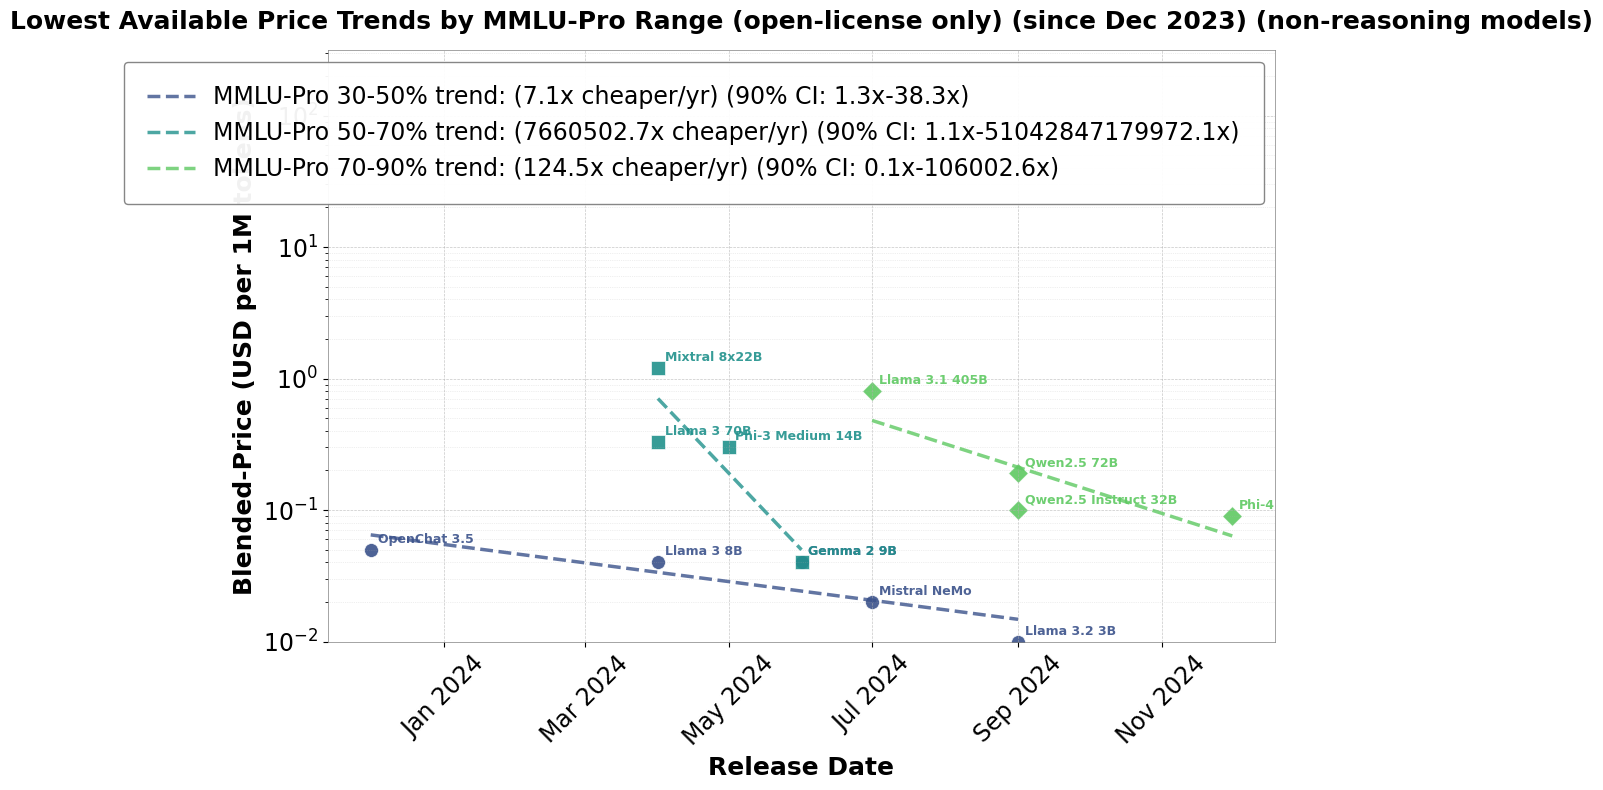

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import scienceplots
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats


# get predictions at highly skewed
#R^2 regression


def plot_combined_record_small_trends(open_license_only=False, price_col='Lowest Blended Price AA', show_model_names=False, min_date=datetime(2023, 1, 1), confidence_interval=True, include_chinese=None, benchmark_col='MMLU-Pro (Reasoning & Knowledge)', mmlu_ranges=[(30, 50), (50, 70), (70, 90)], include_reasoning_models=True):
    """
    Plot record-small points and their trend lines for specified MMLU ranges 
    on a single graph with enhanced styling. Includes 90% confidence intervals.
    
    Parameters:
      open_license_only: If True, only include models with open licenses
      price_col: Column name for price data (default: 'Lowest Blended Price AA')
      show_model_names: If True, displays model names next to record-small points
      min_date: If provided, only include models released on or after this date (datetime or string)
                Default is January 1, 2024
      confidence_interval: If True, displays 90% confidence intervals for trend lines
      include_chinese: Filter for Chinese models - if True, only include Chinese models; 
                      if False, exclude Chinese models; if None, include all models
      benchmark_col: Column name for the benchmark to use (default: 'MMLU-Pro (Reasoning & Knowledge)')
      mmlu_ranges: List of tuples defining MMLU score ranges (default: [(30, 50), (50, 70), (70, 90)])
      include_reasoning_models: If True, include reasoning models; if False, exclude reasoning models (default: True)
    """
    # Set up the styling with standard matplotlib font
    plt.rcParams['font.family'] = 'sans-serif'
    
    # Create figure with specific dimensions
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
    
    # Set background to white
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Use provided MMLU ranges with custom palette
    palette = sns.color_palette("viridis", n_colors=len(mmlu_ranges))
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # Extended list of markers
    
    # --- column names ---
    mmlu_col = benchmark_col
    license_col = 'License'
    chinese_col = 'Chinese'
    reasoning_col = 'Reasoning_TF'
    
    # Store all data for setting axis limits
    all_dates = []
    all_prices = []
    
    for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
        color = palette[i]
        marker = markers[i % len(markers)]  # Cycle through markers if we have more ranges than markers
        
        # 1) Work on a copy
        df_work = df.copy()

        # 2) Convert MMLU "XX%" → float
        df_work[mmlu_col] = (
            df_work[mmlu_col].astype(str)
                             .str.replace('%','',regex=False)
                             .astype(float)
        )

        # 3) Convert price "$X,XXX" → float
        df_work[price_col] = (
            df_work[price_col].astype(str)
                             .str.replace('[$,]','',regex=True)
        )
        df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

        # 4) Optionally filter to open‐license only
        if open_license_only:
            df_work = df_work[
                df_work[license_col].notna() &
                df_work[license_col].str.contains('open', case=False, na=False)
            ]
            
        # 4b) Filter by date if min_date is provided
        if min_date is not None:
            if isinstance(min_date, str):
                min_date = pd.to_datetime(min_date)
            df_work = df_work[df_work['Release Date'] >= min_date]
            
        # 4c) Filter by Chinese models if specified
        if include_chinese is not None:
            if include_chinese:
                # Only include Chinese models (where Chinese column is TRUE)
                df_work = df_work[df_work[chinese_col] == True]
            else:
                # Exclude Chinese models (where Chinese column is TRUE)
                df_work = df_work[(df_work[chinese_col] != True) | (df_work[chinese_col].isna())]
                
        # 4d) Filter by reasoning models if specified
        if not include_reasoning_models:
            # Exclude reasoning models (where Reasoning_TF column is TRUE)
            df_work = df_work[(df_work[reasoning_col] != True) | (df_work[reasoning_col].isna())]

        # 5) Filter to MMLU range
        df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

        # 6) Drop missing Release Date or price, remove non‐positive prices
        df_sub = df_sub.dropna(subset=['Release Date', price_col])
        df_sub = df_sub[df_sub[price_col] > 0]

        # Skip if no data
        if len(df_sub) == 0:
            continue

        # 7) Sort & compute ordinal date
        df_sub = df_sub.sort_values('Release Date')
        df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

        # 8) "Record‐small" = running minima of price
        df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
        record_small = df_sub[df_sub['Is_Record_Small']].copy()
        
        # Skip if no record small points
        if len(record_small) == 0:
            continue

        # 9) Linear regression on record small points (log scale)
        X_rec = record_small['Date_Ordinal'].values.reshape(-1,1)
        y_rec_log = np.log10(record_small[price_col].values)
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        
        # Calculate R^2 value
        r_squared = rec_ols.score(X_rec, y_rec_log)
        print(f"MMLU {min_mmlu}-{max_mmlu}% R² = {r_squared:.3f}")
        
        # 10) Create prediction line
        min_ord, max_ord = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
        x_range = np.arange(min_ord, max_ord + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
        
        # 11) Calculate annual decrease rate
        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365
        
        # Calculate 90% confidence intervals for the slope if requested
        ci_label = ""
        n = len(X_rec)
        if confidence_interval and n > 2:  # Need at least 3 points for confidence interval
            # Calculate residuals and standard error
            y_pred = rec_ols.predict(X_rec)
            residuals = y_rec_log - y_pred
            mse = np.sum(residuals**2) / (n - 2)
            se = np.sqrt(mse / np.sum((X_rec - np.mean(X_rec))**2))
            
            # t-value for 90% confidence interval (two-tailed)
            t_val = stats.t.ppf(0.95, n - 2)
            
            # Confidence interval for slope
            ci_lower = rec_ols.coef_[0] - t_val * se
            ci_upper = rec_ols.coef_[0] + t_val * se
            
            # Convert to annual factors
            annual_factor_lower = 1 / (10**ci_upper)**365  # Note: Upper CI of negative slope gives lower factor
            annual_factor_upper = 1 / (10**ci_lower)**365  # Note: Lower CI of negative slope gives upper factor
            
            ci_label = f" (90% CI: {annual_factor_lower:.1f}x-{annual_factor_upper:.1f}x)"

        # 12) Plot record small points with enhanced styling
        sns.scatterplot(
            x=record_small['Release Date'], 
            y=record_small[price_col],
            color=color, 
            s=100,  # Slightly larger points
            marker=marker, 
            alpha=0.9,
            edgecolor='white',
            linewidth=0.5,
            ax=ax
        )
        
        # 13) Plot trend line with enhanced styling
        ax.plot(
            x_dates, 
            10**y_rec_log_pred, 
            color=color, 
            linestyle='--', 
            linewidth=2.5,
            alpha=0.8,
            label=f'{benchmark_col.split(" ")[0]} {min_mmlu}-{max_mmlu}% trend: ({annual_factor_rec:.1f}x cheaper/yr){ci_label}'
        )
        
        # Plot confidence intervals if we have enough data points and confidence_interval is True
        if confidence_interval and n > 2:
            y_lower = ci_lower * x_range + rec_ols.intercept_
            y_upper = ci_upper * x_range + rec_ols.intercept_
            
            ax.fill_between(
                x_dates,
                10**y_lower,
                10**y_upper,
                color=color,
                alpha=0.1
            )
        
        # 14) Add model names if requested
        if show_model_names:
            for idx, row in record_small.iterrows():
                ax.annotate(
                    row['Model'], 
                    (row['Release Date'], row[price_col]),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9,
                    color=color,
                    fontweight='bold',
                    alpha=0.9
                )
        
        # Store data for axis limits
        all_dates.extend(record_small['Release Date'].tolist())
        all_prices.extend(record_small[price_col].tolist())
    
    # 15) Enhanced formatting
    ax.set_yscale('log')
    ax.set_xlabel('Release Date', fontsize=18, fontweight='bold')
    ax.set_ylabel('Blended-Price (USD per 1M tokens)', fontsize=18, fontweight='bold')
    
    # Format date axis
    date_formatter = DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=45)
    
    # Title with styling
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    date_filter = f" (since {min_date.strftime('%b %Y')})" if min_date is not None else ""
    chinese_filter = " (Chinese models only)" if include_chinese is True else " (non-Chinese models)" if include_chinese is False else ""
    reasoning_filter = " (non-reasoning models)" if not include_reasoning_models else ""
    benchmark_name = benchmark_col.split(" ")[0]  # Extract first part of benchmark name for title
    ax.set_title(f'Lowest Available Price Trends by {benchmark_name} Range ({lic_label}){date_filter}{chinese_filter}{reasoning_filter}',     fontsize=18, fontweight='bold', pad=15)
    
# \n{price_col}


    # Grid styling
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)
    
    # Legend styling
    legend = ax.legend(
        loc='upper right', 
        fontsize=17,
        frameon=True,
        fancybox=True,
        framealpha=0.95,
        edgecolor='gray',
        borderpad=1
    )
    
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=17)
    
    # Add a subtle border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    plt.ylim(10**-2,10**2.5)
    plt.show()

# Usage examples:
# For all licenses:
# plot_combined_record_small_trends(open_license_only=False, price_col="Lowest Blended Price AA", min_date=datetime(2023, 12, 1), confidence_interval=True, show_model_names=True)

# For open licenses only with model names:
plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", confidence_interval=True, min_date=datetime(2023, 12, 1), benchmark_col='MMLU-Pro (Reasoning & Knowledge)', show_model_names=True, include_reasoning_models=False)

# # For Chinese models only:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", include_chinese=True)

# # For non-Chinese models only:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", include_chinese=False)

# # For non-reasoning models only:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", include_reasoning_models=False)

# # Example with custom MMLU ranges:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", mmlu_ranges=[(20, 40), (40, 60), (60, 80), (80, 95)])



#         'GPQA Diamond (Scientific Reasoning)',
# #        'Humanity's Last Exam (Reasoning & Knowledge)',
# #        'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
# #        'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
# #        'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',

# Total Number of Models Available?

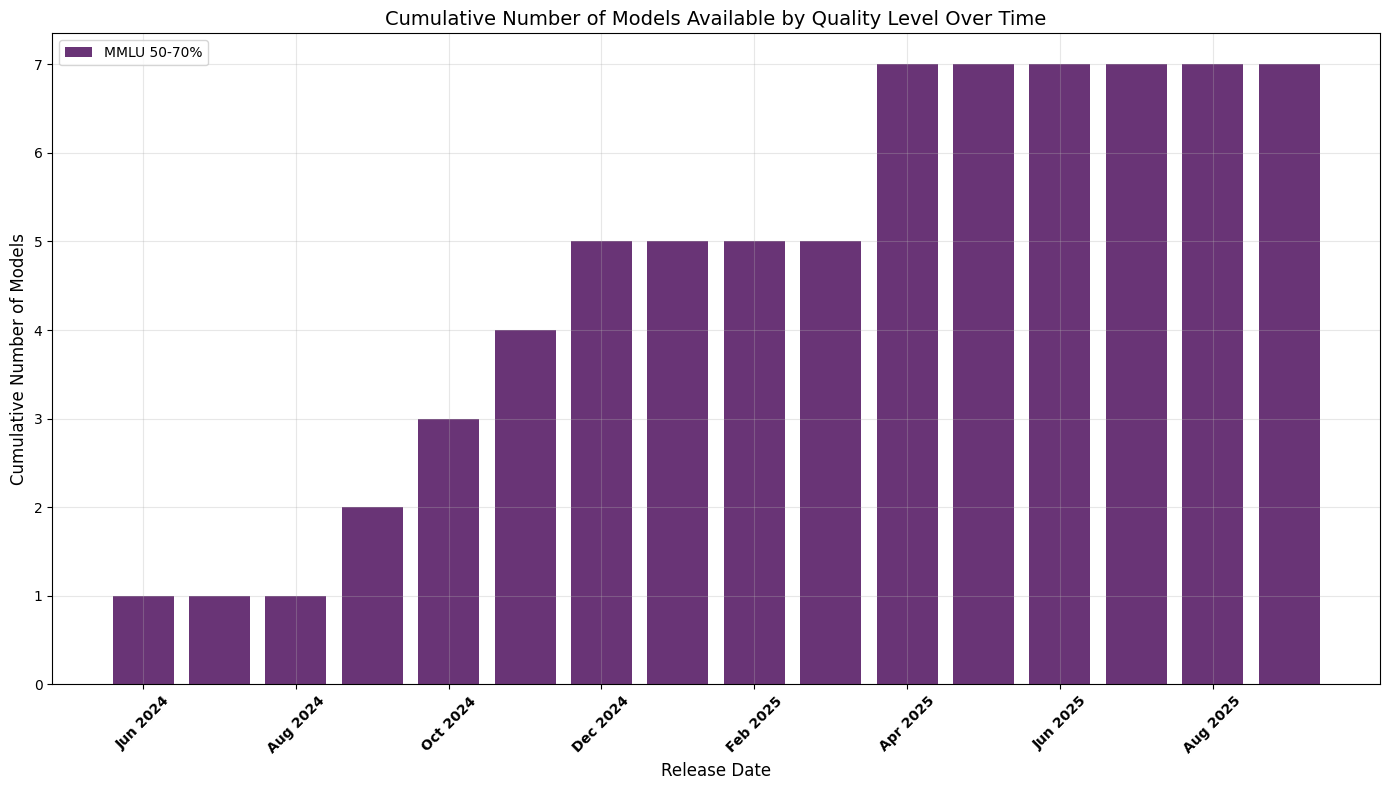

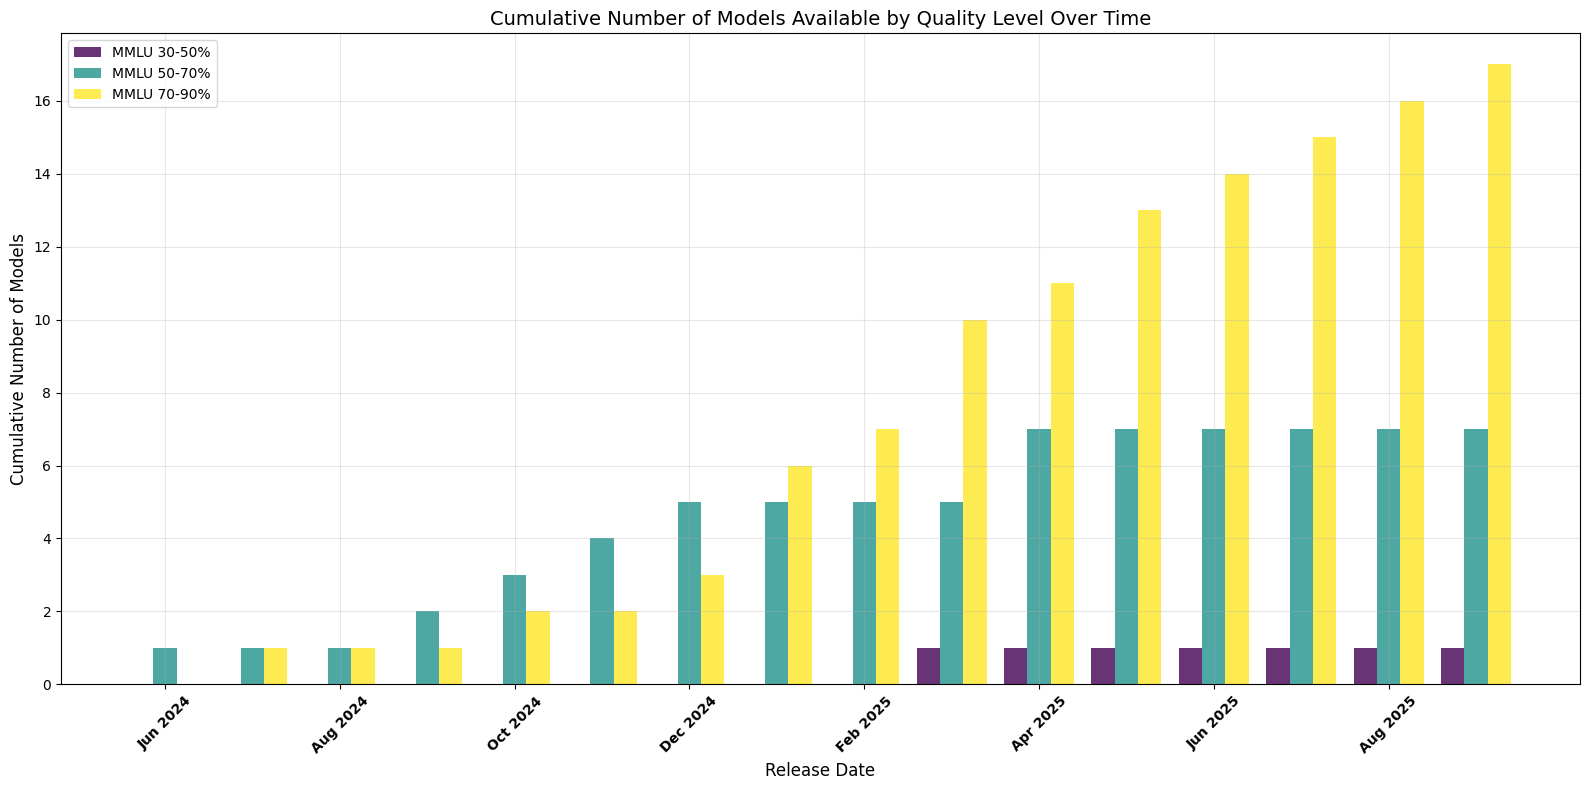

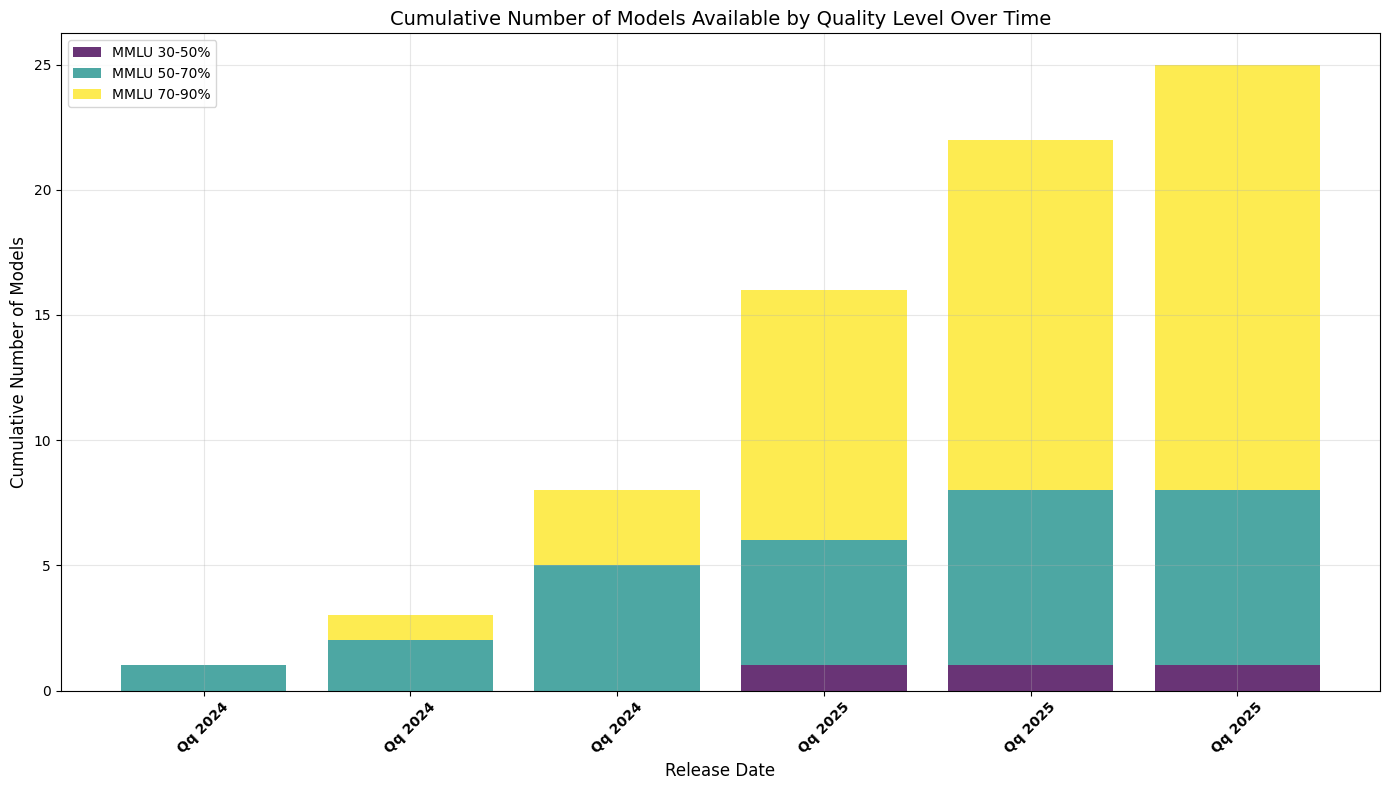

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def plot_cumulative_models_by_quality(quality_ranges=[(50, 70), (70, 85), (85, 100)], 
                                     mmlu_col='MMLU-Pro (Reasoning & Knowledge)',
                                     date_col='Release Date',
                                     freq='M'):
    """
    Plot cumulative number of models available at different quality levels over time.
    
    Parameters:
    - quality_ranges: List of tuples defining MMLU score ranges, e.g., [(50,70), (70,85), (85,100)]
    - mmlu_col: Column name for MMLU scores
    - date_col: Column name for release dates
    - freq: Frequency for time grouping ('M' for monthly, 'Q' for quarterly)
    """
    
    # Load and prepare data
    df_work = df.copy()
    
    # Convert MMLU scores from "XX%" to float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
        .str.replace('%', '', regex=False)
        .str.replace('N/A', 'NaN', regex=False)
        .replace('nan', np.nan)
    )
    df_work[mmlu_col] = pd.to_numeric(df_work[mmlu_col], errors='coerce')
    
    # Convert release date to datetime
    df_work[date_col] = pd.to_datetime(df_work[date_col])
    
    # Filter out rows with missing MMLU or date
    df_work = df_work.dropna(subset=[mmlu_col, date_col])
    
    # Create time periods (monthly or quarterly)
    df_work['Period'] = df_work[date_col].dt.to_period(freq)
    
    # Prepare data for each quality range
    cumulative_data = {}
    colors = plt.cm.viridis(np.linspace(0, 1, len(quality_ranges)))
    
    for min_score, max_score in quality_ranges:
        # Filter models in this quality range
        quality_models = df_work[df_work[mmlu_col].between(min_score, max_score)].copy()
        
        # Group by period and count models
        period_counts = quality_models.groupby('Period').size()
        
        # Get all periods from the earliest to latest
        all_periods = pd.period_range(
            start=df_work['Period'].min(), 
            end=df_work['Period'].max(), 
            freq=freq
        )
        
        # Reindex to include all periods (filling missing with 0)
        period_counts = period_counts.reindex(all_periods, fill_value=0)
        
        # Calculate cumulative sum
        cumulative_counts = period_counts.cumsum()
        
        cumulative_data[f'MMLU {min_score}-{max_score}%'] = cumulative_counts
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Convert periods to datetime for plotting
    x_dates = [period.to_timestamp() for period in cumulative_counts.index]
    
    # Plot bars for each quality range
    width = 20 if freq == 'M' else 60  # Adjust bar width based on frequency
    x_positions = np.arange(len(x_dates))
    
    bottom = np.zeros(len(x_dates))
    
    for i, (label, data) in enumerate(cumulative_data.items()):
        values = data.values
        ax.bar(x_positions, values, width=0.8, bottom=bottom, 
               label=label, color=colors[i], alpha=0.8)
        bottom += values
    
    # Customize the plot
    ax.set_xlabel('Release Date', fontsize=12)
    ax.set_ylabel('Cumulative Number of Models', fontsize=12)
    ax.set_title('Cumulative Number of Models Available by Quality Level Over Time', fontsize=14)
    
    # Set x-axis labels with month names every 2 months
    if freq == 'M':
        # Show every 2 months with month name
        step = 2
        ax.set_xticks(x_positions[::step])
        ax.set_xticklabels([d.strftime('%b %Y') for d in x_dates[::step]], rotation=45, 
                          fontweight='bold', color='black')
    else:
        # For quarterly data
        ax.set_xticks(x_positions)
        ax.set_xticklabels([d.strftime('Q%q %Y') for d in x_dates], rotation=45, 
                          fontweight='bold', color='black')
    
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return cumulative_data

# Alternative version showing separate bars for each quality level (side by side)
def plot_cumulative_models_separate_bars(quality_ranges=[(50, 70), (70, 85), (85, 100)], 
                                        mmlu_col='MMLU-Pro (Reasoning & Knowledge)',
                                        date_col='Release Date',
                                        freq='M'):
    """
    Plot cumulative number of models with separate bars for each quality level.
    """
    
    # Load and prepare data (same as above)
    df_work = df.copy()
    
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
        .str.replace('%', '', regex=False)
        .str.replace('N/A', 'NaN', regex=False)
        .replace('nan', np.nan)
    )
    df_work[mmlu_col] = pd.to_numeric(df_work[mmlu_col], errors='coerce')
    df_work[date_col] = pd.to_datetime(df_work[date_col])
    df_work = df_work.dropna(subset=[mmlu_col, date_col])
    df_work['Period'] = df_work[date_col].dt.to_period(freq)
    
    # Prepare data for each quality range
    cumulative_data = {}
    colors = plt.cm.viridis(np.linspace(0, 1, len(quality_ranges)))
    
    for min_score, max_score in quality_ranges:
        quality_models = df_work[df_work[mmlu_col].between(min_score, max_score)].copy()
        period_counts = quality_models.groupby('Period').size()
        
        all_periods = pd.period_range(
            start=df_work['Period'].min(), 
            end=df_work['Period'].max(), 
            freq=freq
        )
        
        period_counts = period_counts.reindex(all_periods, fill_value=0)
        cumulative_counts = period_counts.cumsum()
        cumulative_data[f'MMLU {min_score}-{max_score}%'] = cumulative_counts
    
    # Create the plot with side-by-side bars
    fig, ax = plt.subplots(figsize=(16, 8))
    
    x_dates = [period.to_timestamp() for period in list(cumulative_data.values())[0].index]
    x_positions = np.arange(len(x_dates))
    
    bar_width = 0.8 / len(quality_ranges)
    
    for i, (label, data) in enumerate(cumulative_data.items()):
        offset = (i - len(quality_ranges)/2 + 0.5) * bar_width
        ax.bar(x_positions + offset, data.values, width=bar_width, 
               label=label, color=colors[i], alpha=0.8)
    
    ax.set_xlabel('Release Date', fontsize=12)
    ax.set_ylabel('Cumulative Number of Models', fontsize=12)
    ax.set_title('Cumulative Number of Models Available by Quality Level Over Time', fontsize=14)
    
    # Set x-axis labels with month names every 2 months
    if freq == 'M':
        # Show every 2 months with month name
        step = 2
        ax.set_xticks(x_positions[::step])
        ax.set_xticklabels([d.strftime('%b %Y') for d in x_dates[::step]], rotation=45, 
                          fontweight='bold', color='black')
    else:
        # For quarterly data
        ax.set_xticks(x_positions)
        ax.set_xticklabels([d.strftime('Q%q %Y') for d in x_dates], rotation=45, 
                          fontweight='bold', color='black')
    
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return cumulative_data

# Example usage:
# For your specific case (MMLU 50-70):
cumulative_data = plot_cumulative_models_by_quality(
    quality_ranges=[(50, 70)], 
    freq='M'  # Monthly grouping
)

# For multiple quality ranges side by side:
cumulative_data_multiple = plot_cumulative_models_separate_bars(
    quality_ranges=[(30, 50), (50, 70), (70, 90)], 
    freq='M'
)

# You can also use quarterly grouping for cleaner visualization:
cumulative_data_quarterly = plot_cumulative_models_by_quality(
    quality_ranges=[(30, 50), (50, 70), (70, 90)], 
    freq='Q'  # Quarterly grouping
)

## Trend in Minimal Parameter Necessary

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from datetime import datetime

def plot_params_small_trend_by_mmlu(min_mmlu, max_mmlu, open_license_only=False, benchmark_name='MMLU-Pro (Reasoning & Knowledge)', use_active_params=False, show_model_names=False):
    """
    Plot number-of-parameters (in billions) vs. release date for models
    with benchmark score ∈ [min_mmlu, max_mmlu], and highlight the record-small trend
    (running minima of model size).
    
    Parameters:
    - min_mmlu, max_mmlu: numeric bounds on benchmark score (%)
    - open_license_only: if True, only include rows where 'License' contains 'open'
    - benchmark_name: name of the benchmark column to use (default: 'MMLU-Pro (Reasoning & Knowledge)')
    - use_active_params: if True, use 'Active Parameters' column instead of 'Parameters'
    - show_model_names: if True, display model names next to record-small points
    
    Assumes `df` is in scope with columns:
      - 'Release Date' (datetime64)
      - benchmark_name (e.g. '75%')
      - 'Parameters' or 'Active Parameters' (absolute count)
      - 'License' (string)
    """
    # column names
    mmlu_col    = benchmark_name
    param_col   = 'Active Parameters' if use_active_params else 'Parameters'  # choose parameter column
    license_col = 'License'             # adjust if needed

    # work on a copy
    df_work = df.copy()

    # 1) Convert benchmark score "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%', '', regex=False)
                         .astype(float)
    )

    # 2) Convert parameter counts → numeric; scale to billions
    df_work[param_col] = pd.to_numeric(df_work[param_col], errors='coerce')
    df_work['Params_B'] = df_work[param_col]

    # 3) Optionally filter to open-licensed models
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 4) Filter to benchmark score range
    df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

    # 5) Drop missing dates or sizes; remove non-positive sizes
    df_sub = df_sub.dropna(subset=['Release Date', 'Params_B'])
    df_sub = df_sub[df_sub['Params_B'] > 0]

    # 6) Sort & compute ordinal dates
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
    
    # Check if we have enough data points to proceed
    if len(df_sub) < 1:
        print(f"Warning: No data points found for the specified criteria. "
              f"MMLU range: [{min_mmlu}, {max_mmlu}], Open license only: {open_license_only}, "
              f"Using {param_col}")
        return
    
    # 7) Prepare X, y (log10 of Params_B)
    X     = df_sub['Date_Ordinal'].values.reshape(-1, 1)
    y_log = np.log10(df_sub['Params_B'].values)

    # 8) Fit overall OLS & median QuantileRegressor
    ols = LinearRegression().fit(X, y_log)
    qr  = QuantileRegressor(quantile=0.5, alpha=0.0).fit(X, y_log)

    # 9) Build daily grid for predictions
    lo, hi    = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range   = np.arange(lo, hi + 1)
    x_dates   = [datetime.fromordinal(int(d)) for d in x_range]
    y_ols_log = ols.predict(x_range.reshape(-1, 1))
    y_qr_log  = qr.predict(x_range.reshape(-1, 1))

    # 10) Annualized growth rates
    annual_pct_ols = ((10**ols.coef_[0])**365 - 1) * 100
    annual_pct_qr  = ((10**qr.coef_[0])**365 - 1) * 100
    
    # Calculate factor decreases (for negative percentages)
    factor_ols = 1 / (1 + annual_pct_ols/100) if annual_pct_ols < 0 else None
    factor_qr = 1 / (1 + annual_pct_qr/100) if annual_pct_qr < 0 else None

    # 11) Identify record-small points (running minima of size)
    df_sub['Is_Record_Small'] = df_sub['Params_B'].cummin() == df_sub['Params_B']
    record_small = df_sub[df_sub['Is_Record_Small']].copy()

    # 12) Fit OLS on record-small points
    X_rec = record_small['Date_Ordinal'].values.reshape(-1, 1)
    y_rec_log = np.log10(record_small['Params_B'].values)
    
    # Only proceed with record small trend if we have at least one data point
    if len(record_small) >= 1:
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1, 1))
        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        factor_rec = 1 / (1 + annual_pct_rec/100) if annual_pct_rec < 0 else None
    else:
        rec_ols = None
        y_rec_log_pred = None
        annual_pct_rec = None
        factor_rec = None

    # 13) Plot
    plt.figure(figsize=(10, 6))

    # a) All models
    plt.scatter(
        df_sub['Release Date'], df_sub['Params_B'],
        color='gray', alpha=0.3, label='All models'
    )
    # b) Overall OLS trend
    ols_label = f'OLS trend: {annual_pct_ols:.2f}%/yr'
    if factor_ols:
        ols_label += f' ({factor_ols:.2f}× decrease/yr)'
    plt.plot(
        x_dates, 10**y_ols_log,
        'r-', lw=2, label=ols_label
    )
    # c) Median quantile trend
    qr_label = f'50th-quantile trend: {annual_pct_qr:.2f}%/yr'
    if factor_qr:
        qr_label += f' ({factor_qr:.2f}× decrease/yr)'
    plt.plot(
        x_dates, 10**y_qr_log,
        'b-.', lw=2, label=qr_label
    )
    
    # d & e) Only plot record small trend if we have data
    if len(record_small) >= 1:
        # d) Record-small points
        plt.scatter(
            record_small['Release Date'], record_small['Params_B'],
            color='tab:green', s=80, marker='v',
            label='Record-small points'
        )
        
        # Add model names if requested
        if show_model_names and 'Model' in record_small.columns:
            for i, row in record_small.iterrows():
                plt.annotate(
                    row['Model'],
                    (row['Release Date'], row['Params_B']),
                    xytext=(5, 0),
                    textcoords='offset points',
                    fontsize=8,
                    va='center'
                )
                
        # e) Record-small OLS trend
        if rec_ols is not None:
            rec_label = f'Record-small trend: {annual_pct_rec:.2f}%/yr'
            if factor_rec:
                rec_label += f' ({factor_rec:.2f}× decrease/yr)'
            plt.plot(
                x_dates, 10**y_rec_log_pred,
                'g--', lw=2,
                label=rec_label
            )

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Parameters (billion)')
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    param_type = 'Active Parameters' if use_active_params else 'Parameters'
    benchmark_short = benchmark_name.split(' ')[0]
    plt.title(f'Model-size Trend ({benchmark_short} ∈ [{min_mmlu},{max_mmlu}]%, {lic_label}, {param_type})')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend()
    plt.show()


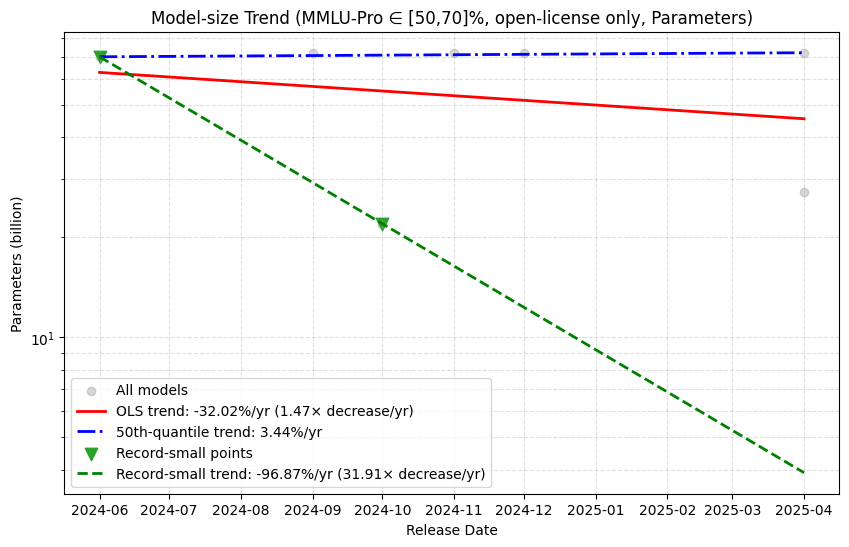

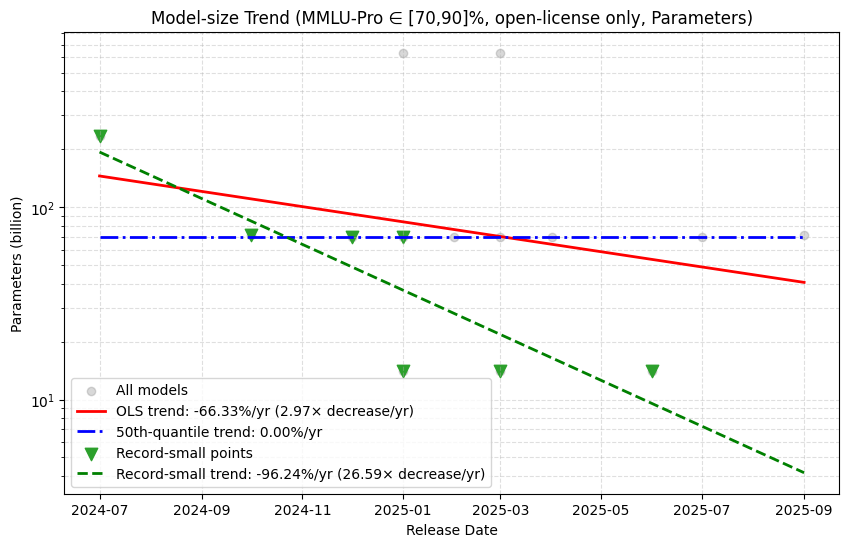

In [12]:
plot_params_small_trend_by_mmlu(30, 50, open_license_only=True, use_active_params=False)
plot_params_small_trend_by_mmlu(50, 70, open_license_only=True, use_active_params=False)
plot_params_small_trend_by_mmlu(70, 90, open_license_only=True, use_active_params=False)


## Active Parameters

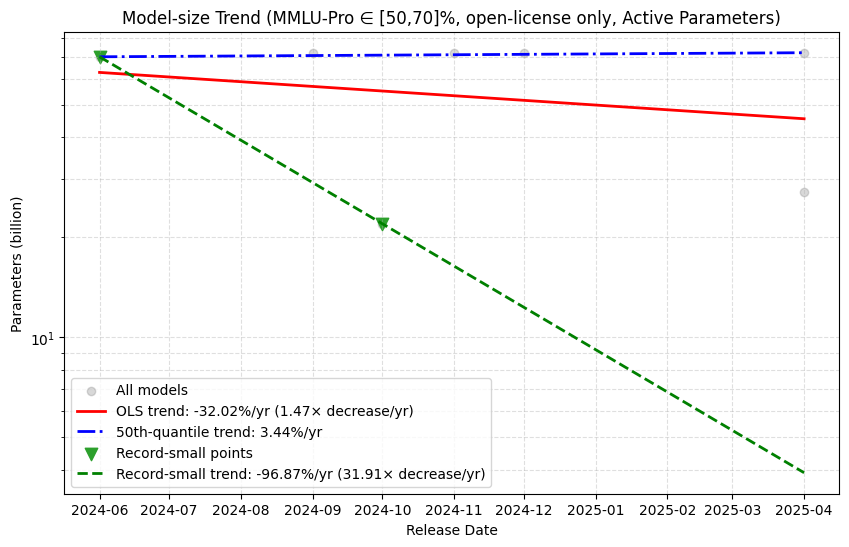

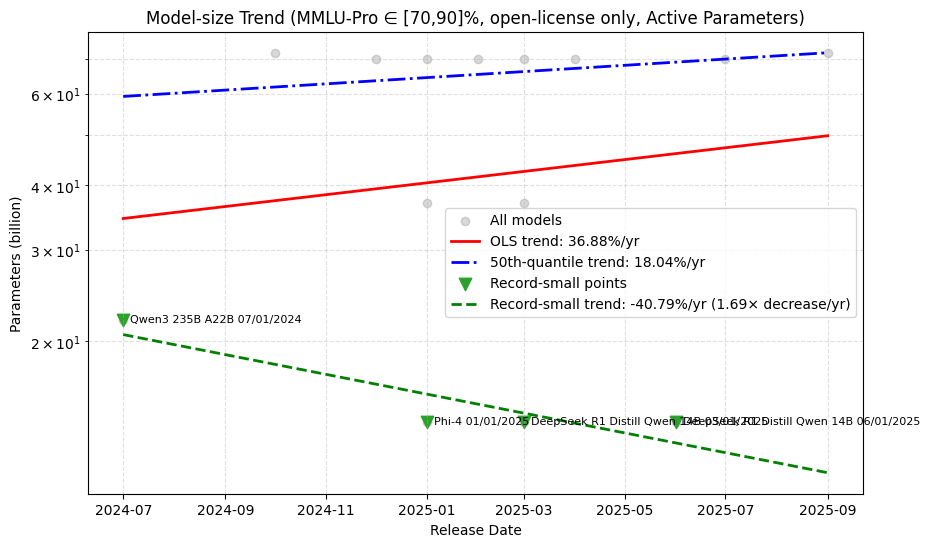

In [13]:
plot_params_small_trend_by_mmlu(30, 50, open_license_only=True, use_active_params=True)
plot_params_small_trend_by_mmlu(50, 70, open_license_only=True, use_active_params=True)
plot_params_small_trend_by_mmlu(70, 90, open_license_only=True, use_active_params=True, show_model_names=True)


## Nicer Looking Version of Plot Combined Trends in Active Parameters

Not enough data for MMLU range 30-50 to plot a trend.
MMLU range 50-70: R² = 1.000
MMLU range 70-90: R² = 0.807


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_87808/2698664317.py:159: RuntimeWarning: overflow encountered in power
  10**y_upper,


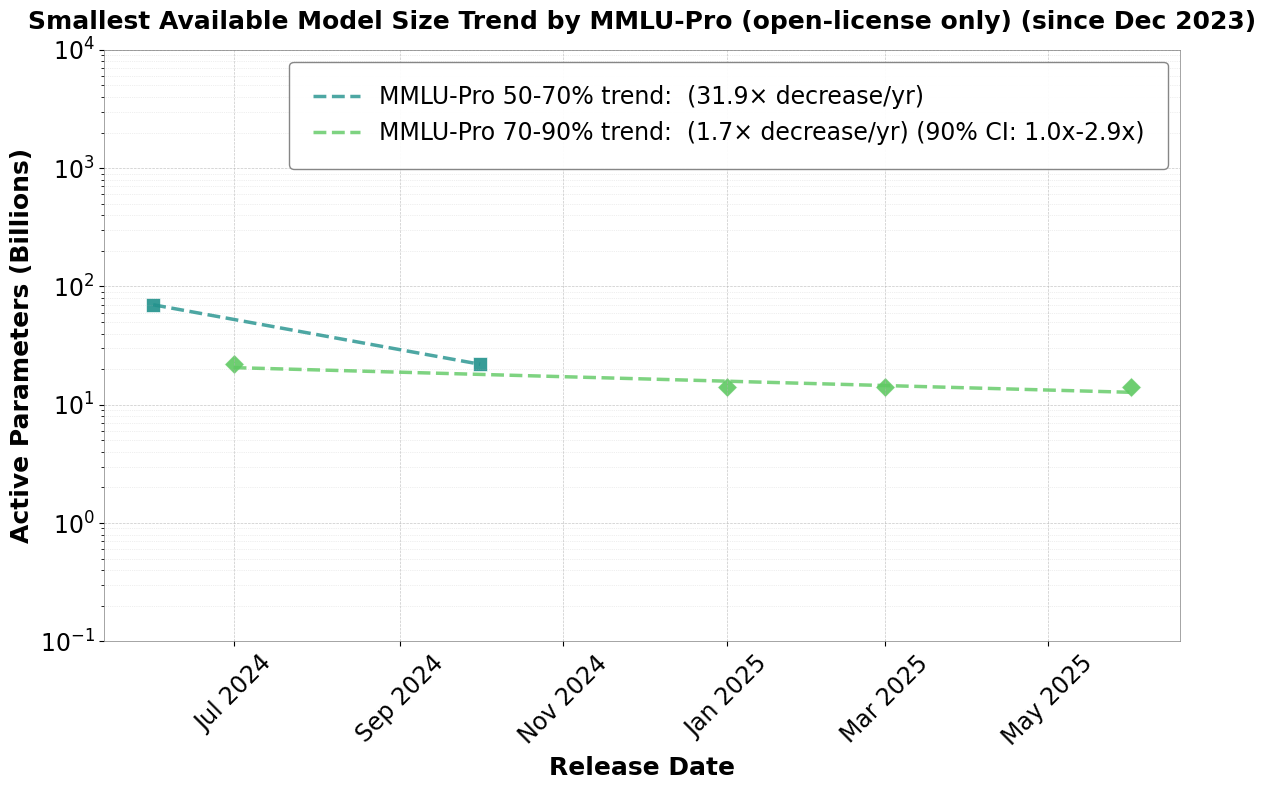

In [14]:
import seaborn as sns

def plot_combined_params_trend(open_license_only=False, use_active_params=True, show_model_names=False, 
                              benchmark_name='MMLU-Pro (Reasoning & Knowledge)', min_date=None, confidence_interval=True):
    """
    Plot record-small parameter trends for three MMLU ranges (30-50, 50-70, 70-90) 
    on a single graph with enhanced styling.
    
    Parameters:
      - open_license_only: if True, only include models where 'License' contains 'open'
      - use_active_params: if True, use 'Active Parameters'; else, use 'Parameters'
      - show_model_names: if True, display model names next to record-small points
      - benchmark_name: name of the benchmark column to use
      - min_date: If provided, only include models released on or after this date (datetime or string)
      - confidence_interval: If True, displays 90% confidence intervals for trend lines
    """
    # Set up the styling with standard matplotlib font
    plt.rcParams['font.family'] = 'sans-serif'
    
    # Create figure with specific dimensions
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
    
    # Set background to white
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Define MMLU ranges with custom palette
    mmlu_ranges = [(30, 50), (50, 70), (70, 90)]
    palette = sns.color_palette("viridis", n_colors=len(mmlu_ranges))
    markers = ['o', 's', 'D']  # Circle, square, diamond
    
    # Column names
    mmlu_col = benchmark_name
    param_col = 'Active Parameters' if use_active_params else 'Parameters'
    license_col = 'License'

    # Loop over MMLU ranges
    for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
        color = palette[i]
        marker = markers[i]
        
        # --- Data Preparation ---
        df_work = df.copy()

        df_work[mmlu_col] = (
            df_work[mmlu_col].astype(str)
                             .str.replace('%', '', regex=False)
                             .astype(float)
        )
        
        df_work[param_col] = pd.to_numeric(df_work[param_col], errors='coerce')
        df_work['Params_B'] = df_work[param_col]

        if open_license_only:
            df_work = df_work[
                df_work[license_col].notna() &
                df_work[license_col].str.contains('open', case=False, na=False)
            ]
            
        # Filter by date if min_date is provided
        if min_date is not None:
            if isinstance(min_date, str):
                min_date = pd.to_datetime(min_date)
            df_work = df_work[df_work['Release Date'] >= min_date]

        df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()
        
        df_sub = df_sub.dropna(subset=['Release Date', 'Params_B'])
        df_sub = df_sub[df_sub['Params_B'] > 0]
        
        if len(df_sub) < 2:
            print(f"Not enough data for MMLU range {min_mmlu}-{max_mmlu} to plot a trend.")
            continue
            
        # --- Record-Small Calculation & Regression ---
        df_sub = df_sub.sort_values('Release Date')
        df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
        
        df_sub['Is_Record_Small'] = df_sub['Params_B'].cummin() == df_sub['Params_B']
        record_small = df_sub[df_sub['Is_Record_Small']].copy()
        
        if len(record_small) < 2:
            print(f"Not enough record-small points for MMLU range {min_mmlu}-{max_mmlu} to plot a trend.")
            continue

        X_rec = record_small['Date_Ordinal'].values.reshape(-1, 1)
        y_rec_log = np.log10(record_small['Params_B'].values)
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        
        # Calculate R^2 score
        r2_score = rec_ols.score(X_rec, y_rec_log)
        print(f"MMLU range {min_mmlu}-{max_mmlu}: R² = {r2_score:.3f}")
        
        lo, hi = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
        x_range = np.arange(lo, hi + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1, 1))

        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        factor_rec_str = ""
        if annual_pct_rec < 0:
            factor_rec = 1 / (1 + annual_pct_rec / 100)
            factor_rec_str = f' ({factor_rec:.1f}× decrease/yr)'
        
        # Calculate 90% confidence intervals for the slope if requested
        ci_label = ""
        n = len(X_rec)
        if confidence_interval and n > 2:  # Need at least 3 points for confidence interval
            # Calculate residuals and standard error
            y_pred = rec_ols.predict(X_rec)
            residuals = y_rec_log - y_pred
            mse = np.sum(residuals**2) / (n - 2)
            se = np.sqrt(mse / np.sum((X_rec - np.mean(X_rec))**2))
            
            # t-value for 90% confidence interval (two-tailed)
            from scipy import stats
            t_val = stats.t.ppf(0.95, n - 2)
            
            # Confidence interval for slope
            ci_lower = rec_ols.coef_[0] - t_val * se
            ci_upper = rec_ols.coef_[0] + t_val * se
            
            if annual_pct_rec < 0:  # Decreasing trend
                # For decreasing trends, convert to decrease factors
                factor_lower = 1 / (1 + ((10**ci_upper)**365 - 1))
                factor_upper = 1 / (1 + ((10**ci_lower)**365 - 1))
                ci_label = f" (90% CI: {factor_lower:.1f}x-{factor_upper:.1f}x)"
        
        # --- Enhanced Plotting ---
        sns.scatterplot(
            x=record_small['Release Date'], 
            y=record_small['Params_B'],
            color=color, 
            s=100,  # Slightly larger points
            marker=marker, 
            alpha=0.9,
            edgecolor='white',
            linewidth=0.5,
            ax=ax
        )
        
        ax.plot(
            x_dates, 10**y_rec_log_pred,
            color=color, 
            linestyle='--', 
            linewidth=2.5,
            alpha=0.8,
            label=f'MMLU-Pro {min_mmlu}-{max_mmlu}% trend: {factor_rec_str}{ci_label}'
        )
        # {annual_pct_rec:.1f}%/yr
        # Plot confidence intervals if we have enough data points and confidence_interval is True
        if confidence_interval and n > 2:
            y_lower = ci_lower * x_range + rec_ols.intercept_
            y_upper = ci_upper * x_range + rec_ols.intercept_
            
            ax.fill_between(
                x_dates,
                10**y_lower,
                10**y_upper,
                color=color,
                alpha=0.1
            )

        if show_model_names and 'Model' in record_small.columns:
            for _, row in record_small.iterrows():
                ax.annotate(
                    row['Model'], 
                    (row['Release Date'], row['Params_B']),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9,
                    color=color,
                    fontweight='bold',
                    alpha=0.9
                )
    
    # --- Enhanced Final Plot Formatting ---
    ax.set_yscale('log')
    ax.set_xlabel('Release Date', fontsize=18, fontweight='bold')
    param_type_label = 'Active Parameters' if use_active_params else 'Parameters'
    ax.set_ylabel(f'{param_type_label} (Billions)', fontsize=18, fontweight='bold')
    
    # Format date axis
    from matplotlib.dates import DateFormatter
    date_formatter = DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=45)
    
    # Title with enhanced styling
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    benchmark_short = benchmark_name.split(' ')[0]
    date_filter = f" (since {min_date.strftime('%b %Y')})" if min_date is not None else ""
    ax.set_title(f'Smallest Available Model Size Trend by {benchmark_short} ({lic_label}){date_filter}', 
                fontsize=18, fontweight='bold', pad=15)
    
    # Grid styling
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)
    
    # Legend styling
    legend = ax.legend(
        loc='upper right', 
        fontsize=17,
        frameon=True,
        fancybox=True,
        framealpha=0.95,
        edgecolor='gray',
        borderpad=1
    )
    
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=17)
    
    # Add a subtle border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    plt.ylim(10**-1, 10**4)
    plt.tight_layout()
    plt.show()



# plot_combined_params_trend(open_license_only=False, use_active_params=True, show_model_names=False, confidence_interval=True)
# Example usage for open-license models, showing model names
plot_combined_params_trend(open_license_only=True, use_active_params=True, show_model_names=False, 
                          min_date=datetime(2023, 12, 1), confidence_interval=True)

# Example usage for all models with confidence intervals


# Parameters Per Dollar

In [15]:


def plot_params_small_trend_by_mmlu(min_mmlu,
                                    max_mmlu,
                                    open_license_only=False,
                                    benchmark_name='MMLU-Pro (Reasoning & Knowledge)',
                                    use_active_params=False,
                                    price_column='Output Price\nUSD/1M Tokens'):
    """
    Same inputs as before, but y‐axis = dollars per parameter:
      cost_per_param = (Output Price $/1M tokens) / (# parameters)
    
    Parameters:
    - min_mmlu, max_mmlu: numeric bounds on benchmark_name (%)
    - open_license_only: if True, only include rows where 'License' contains 'open'
    - benchmark_name: column name for the benchmark (default MMLU-Pro)
    - use_active_params: if True, use 'Active Parameters' instead of 'Parameters'
    - price_column: column to use for price data (default 'Output Price\nUSD/1M Tokens')
    """
    # 0) Column keys
    mmlu_col    = benchmark_name
    price_col   = price_column
    param_col   = 'Active Parameters' if use_active_params else 'Parameters'
    license_col = 'License'

    df_work = df.copy()

    # 1) Parse benchmark → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%','',regex=False)
                         .astype(float)
    )
    # 2) Parse price → float ($ per 1M tokens)
    df_work[price_col] = (
        df_work[price_col].astype(str)
                         .str.replace('[$,]','',regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    # 3) Parse params → float
    df_work[param_col] = pd.to_numeric(df_work[param_col], errors='coerce')

    # 4) Optional license filter
    if open_license_only:
        df_work = df_work[
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 5) Filter by benchmark range
    df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

    # 6) Drop missing / non-positive
    df_sub = df_sub.dropna(subset=['Release Date', price_col, param_col])
    df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[param_col] > 0)]

    # 7) Compute cost per parameter
    df_sub['Cost_per_Param'] = df_sub[price_col] / df_sub[param_col]

    # 8) Sort & date ordinals
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

    # 9) Prepare X, y = log10(cost_per_param)
    X     = df_sub['Date_Ordinal'].values.reshape(-1,1)
    y_log = np.log10(df_sub['Cost_per_Param'].values)

    # 10) Fit overall OLS & median QuantileRegressor
    ols = LinearRegression().fit(X, y_log)
    qr  = QuantileRegressor(quantile=0.1, alpha=0.0).fit(X, y_log)

    # 11) Build prediction grid
    lo, hi    = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range   = np.arange(lo, hi+1)
    x_dates   = [datetime.fromordinal(int(d)) for d in x_range]
    y_ols_log = ols.predict(x_range.reshape(-1,1))
    y_qr_log  = qr.predict(x_range.reshape(-1,1))

    # 12) Compute annualized % growth
    annual_pct_ols = ((10**ols.coef_[0])**365 - 1) * 100
    annual_pct_qr  = ((10**qr.coef_[0])**365 - 1) * 100
    
    # Calculate factor decrease per year
    factor_ols = 1 / (1 + annual_pct_ols/100) if annual_pct_ols < 0 else 1 + annual_pct_ols/100
    factor_qr = 1 / (1 + annual_pct_qr/100) if annual_pct_qr < 0 else 1 + annual_pct_qr/100

    # 13) Identify "record‐small" cost points
    df_sub['Is_Record_Small'] = df_sub['Cost_per_Param'].cummin() == df_sub['Cost_per_Param']
    record_small = df_sub[df_sub['Is_Record_Small']].copy()

    # 14) OLS on record‐small
    X_rec          = record_small['Date_Ordinal'].values.reshape(-1,1)
    y_rec_log      = np.log10(record_small['Cost_per_Param'].values)
    rec_ols        = LinearRegression().fit(X_rec, y_rec_log)
    y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
    annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
    
    # Calculate factor decrease for record-small trend
    factor_rec = 1 / (1 + annual_pct_rec/100) if annual_pct_rec < 0 else 1 + annual_pct_rec/100

    # 15) Plot
    plt.figure(figsize=(10,6))
    # all models
    plt.scatter(df_sub['Release Date'], df_sub['Cost_per_Param'],
                color='gray', alpha=0.3, label='All models')
    # overall OLS
    plt.plot(x_dates, 10**y_ols_log, 'r-', lw=2,
             label=f'OLS trend: {annual_pct_ols:.2f}%/yr ({factor_ols:.2f}x/yr)')
    # median quantile
    plt.plot(x_dates, 10**y_qr_log, 'b-.', lw=2,
             label=f'50th-quantile: {annual_pct_qr:.2f}%/yr ({factor_qr:.2f}x/yr)')
    # record‐small points
    plt.scatter(record_small['Release Date'], record_small['Cost_per_Param'],
                color='tab:green', s=80, marker='v',
                label='Record-small cost')
    # record‐small trend
    plt.plot(x_dates, 10**y_rec_log_pred, 'g--', lw=2,
             label=f'Record-small trend: {annual_pct_rec:.2f}%/yr ({factor_rec:.2f}x/yr)')

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Cost per parameter\n($ per 1M tokens ÷ # params)')
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    price_type = price_col.replace('\n', ' ')
    plt.title(f'Cost-per-Param Trend ({mmlu_col} ∈ [{min_mmlu},{max_mmlu}]%, {lic_label}, {price_type}) \n active params: {use_active_params}')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend()
    plt.show()

In [ ]:
plot_params_small_trend_by_mmlu(30, 50, open_license_only=True, use_active_params=True, price_column="Benchmark Cost USD")
plot_params_small_trend_by_mmlu(50, 70, open_license_only=True, use_active_params=True, price_column="Lowest Blended Price AA")
plot_params_small_trend_by_mmlu(70, 90, open_license_only=True, use_active_params=True, price_column="Benchmark Cost USD")

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

## Nicer Looking Version of Plotting Price Per Param Trend

MMLU range 30-50: R² = 0.671
MMLU range 50-70: R² = 0.503
MMLU range 70-90: R² = 1.000


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_69340/3820130347.py:163: RuntimeWarning: overflow encountered in power
  10**y_upper,
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_69340/3820130347.py:163: RuntimeWarning: overflow encountered in power
  10**y_upper,


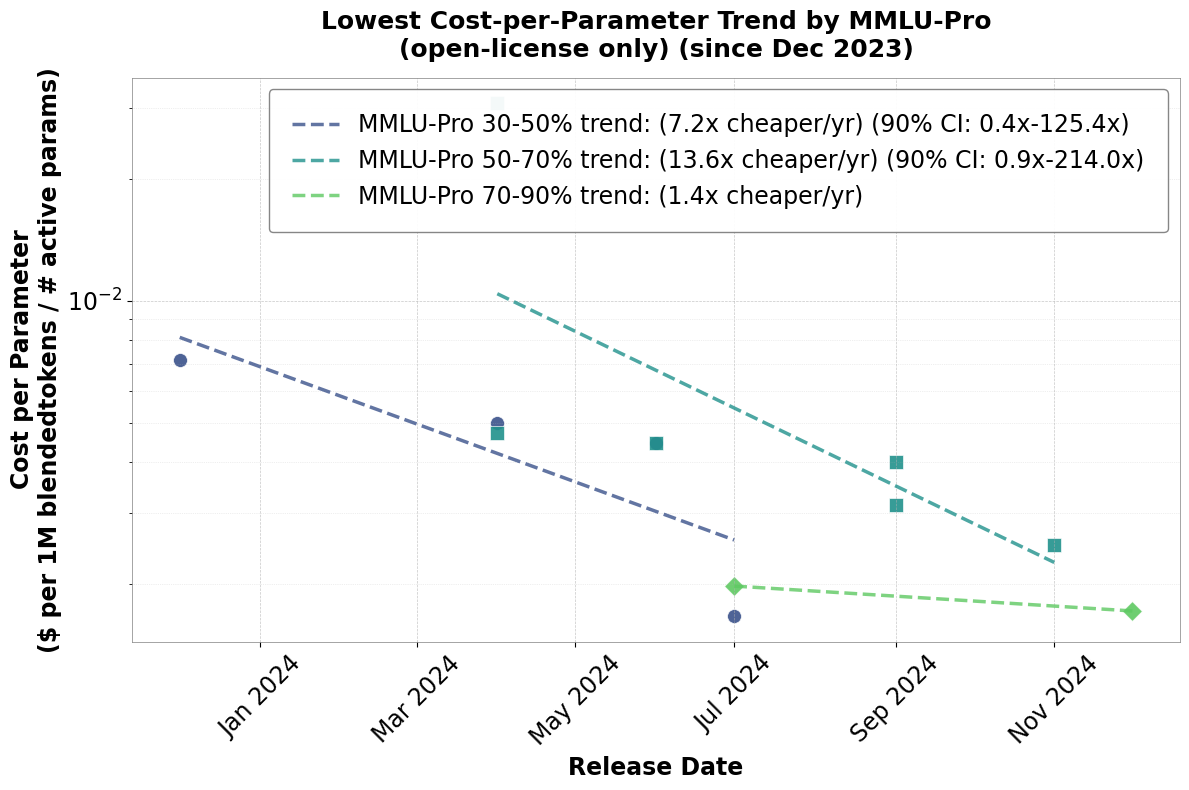

In [ ]:
def plot_combined_cost_per_param_trend(open_license_only=False, 
                                     benchmark_name='MMLU-Pro (Reasoning & Knowledge)', 
                                     use_active_params=False, 
                                     price_column='Output Price\nUSD/1M Tokens', 
                                     show_model_names=False,
                                     min_date=None,
                                     confidence_interval=True):
    """
    Plots record-small cost-per-parameter trends for three MMLU ranges 
    (30-50, 50-70, 70-90) on a single graph with enhanced styling.
    
    y-axis = (Price per 1M tokens) / (# of parameters)
    
    Parameters:
    - open_license_only: if True, filter for open-license models.
    - benchmark_name: The benchmark column to use.
    - use_active_params: if True, use 'Active Parameters'; else, 'Parameters'.
    - price_column: The price column to use.
    - show_model_names: if True, annotate record-small points with model names.
    - min_date: If provided, only include models released on or after this date (datetime or string)
    - confidence_interval: If True, displays 90% confidence intervals for trend lines
    """
    # Set up the styling with standard matplotlib font
    plt.rcParams['font.family'] = 'sans-serif'
    
    # Create figure with specific dimensions
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
    
    # Set background to white
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Define MMLU ranges with custom palette
    mmlu_ranges = [(30, 50), (50, 70), (70, 90)]
    palette = sns.color_palette("viridis", n_colors=len(mmlu_ranges))
    markers = ['o', 's', 'D']  # Circle, square, diamond

    # Column names
    mmlu_col = benchmark_name
    price_col = price_column
    param_col = 'Active Parameters' if use_active_params else 'Parameters'
    license_col = 'License'

    for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
        color = palette[i]
        marker = markers[i]
        
        df_work = df.copy()

        # 1) Parse columns to numeric types
        df_work[mmlu_col] = pd.to_numeric(df_work[mmlu_col].astype(str).str.replace('%', '', regex=False), errors='coerce')
        df_work[price_col] = pd.to_numeric(df_work[price_col].astype(str).str.replace('[$,]', '', regex=True), errors='coerce')
        df_work[param_col] = pd.to_numeric(df_work[param_col], errors='coerce')

        # 2) Filter data
        if open_license_only:
            df_work = df_work[
                df_work[license_col].notna() &
                df_work[license_col].str.contains('open', case=False, na=False)
            ]
            
        # Filter by date if min_date is provided
        if min_date is not None:
            if isinstance(min_date, str):
                min_date = pd.to_datetime(min_date)
            df_work = df_work[df_work['Release Date'] >= min_date]
        
        df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()
        
        # 3) Drop invalid data and compute cost per parameter
        df_sub = df_sub.dropna(subset=['Release Date', price_col, param_col])
        df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[param_col] > 0)]
        
        if len(df_sub) < 2:
            print(f"Not enough data for MMLU range {min_mmlu}-{max_mmlu} to plot a trend.")
            continue
            
        df_sub['Cost_per_Param'] = df_sub[price_col] / df_sub[param_col]
        
        # 4) Identify record-small points based on cost
        df_sub = df_sub.sort_values('Release Date')
        df_sub['Is_Record_Small'] = df_sub['Cost_per_Param'].cummin() == df_sub['Cost_per_Param']
        record_small = df_sub[df_sub['Is_Record_Small']].copy()
        
        if len(record_small) < 2:
            print(f"Not enough record-small points for MMLU range {min_mmlu}-{max_mmlu} to plot a trend.")
            continue

        # 5) Perform linear regression on log-cost
        record_small['Date_Ordinal'] = record_small['Release Date'].map(datetime.toordinal)
        X_rec = record_small['Date_Ordinal'].values.reshape(-1, 1)
        y_rec_log = np.log10(record_small['Cost_per_Param'].values)
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        
        # Calculate R^2 score
        r2_score = rec_ols.score(X_rec, y_rec_log)
        print(f"MMLU range {min_mmlu}-{max_mmlu}: R² = {r2_score:.3f}")

        # 6) Create prediction data for the trend line
        lo, hi = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
        x_range = np.arange(lo, hi + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1, 1))

        # 7) Calculate annualized change
        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365
        
        # Calculate 90% confidence intervals for the slope if requested
        ci_label = ""
        n = len(X_rec)
        if confidence_interval and n > 2:  # Need at least 3 points for confidence interval
            # Calculate residuals and standard error
            y_pred = rec_ols.predict(X_rec)
            residuals = y_rec_log - y_pred
            mse = np.sum(residuals**2) / (n - 2)
            se = np.sqrt(mse / np.sum((X_rec - np.mean(X_rec))**2))
            
            # t-value for 90% confidence interval (two-tailed)
            t_val = stats.t.ppf(0.95, n - 2)
            
            # Confidence interval for slope
            ci_lower = rec_ols.coef_[0] - t_val * se
            ci_upper = rec_ols.coef_[0] + t_val * se
            
            # Convert to annual factors
            annual_factor_lower = 1 / (10**ci_upper)**365  # Note: Upper CI of negative slope gives lower factor
            annual_factor_upper = 1 / (10**ci_lower)**365  # Note: Lower CI of negative slope gives upper factor
            
            ci_label = f" (90% CI: {annual_factor_lower:.1f}x-{annual_factor_upper:.1f}x)"
        
        # 8) Plot points and trend line with enhanced styling
        sns.scatterplot(
            x=record_small['Release Date'], 
            y=record_small['Cost_per_Param'],
            color=color, 
            s=100,  # Slightly larger points
            marker=marker, 
            alpha=0.9,
            edgecolor='white',
            linewidth=0.5,
            ax=ax
        )
        
        ax.plot(
            x_dates, 
            10**y_rec_log_pred,
            color=color, 
            linestyle='--', 
            linewidth=2.5,
            alpha=0.8,
            label=f'MMLU-Pro {min_mmlu}-{max_mmlu}% trend: ({annual_factor_rec:.1f}x cheaper/yr){ci_label}'
        )
        
        # Plot confidence intervals if we have enough data points and confidence_interval is True
        if confidence_interval and n > 2:
            y_lower = ci_lower * x_range + rec_ols.intercept_
            y_upper = ci_upper * x_range + rec_ols.intercept_
            
            ax.fill_between(
                x_dates,
                10**y_lower,
                10**y_upper,
                color=color,
                alpha=0.1
            )
        
        if show_model_names and 'Model' in record_small.columns:
            for _, row in record_small.iterrows():
                ax.annotate(
                    row['Model'], 
                    (row['Release Date'], row['Cost_per_Param']),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9,
                    color=color,
                    fontweight='bold',
                    alpha=0.9
                )

    # 9) Enhanced final plot formatting
    ax.set_yscale('log')
    ax.set_xlabel('Release Date', fontsize=17, fontweight='bold')
    ax.set_ylabel('Cost per Parameter\n($ per 1M blendedtokens / # active params)', fontsize=17, fontweight='bold')
    
    # Format date axis
    date_formatter = DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=45)
    
    # Title with enhanced styling
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    param_type_label = 'Active' if use_active_params else 'Total'
    price_type_label = price_column.split('\n')[0]
    date_filter = f" (since {min_date.strftime('%b %Y')})" if min_date is not None else ""
    ax.set_title(f'Lowest Cost-per-Parameter Trend by MMLU-Pro\n({lic_label}){date_filter}', 
                fontsize=18, fontweight='bold', pad=15)
    
    # Grid styling
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)
    
    # Legend styling
    legend = ax.legend(
        loc='upper right', 
        fontsize=17,
        frameon=True,
        fancybox=True,
        framealpha=0.95,
        edgecolor='gray',
        borderpad=1
    )
    
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=17)
    
    # Add a subtle border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    plt.show()

# --- Enhanced Example Usage ---
# Call the function for open-license models using active parameters and the specified price column.
plot_combined_cost_per_param_trend(
    open_license_only=True, 
    use_active_params=True, 
    price_column="Lowest Blended Price AA",
    show_model_names=False,
    min_date=datetime(2023, 12, 1),
    confidence_interval=True
)

# Example with all licenses and confidence intervals
# plot_combined_cost_per_param_trend(
#     open_license_only=False, 
#     use_active_params=True, 
#     price_column="Lowest Blended Price AA",
#     show_model_names=False,
#     confidence_interval=True
# )

## Naive Overall Trends Using Joint Regression

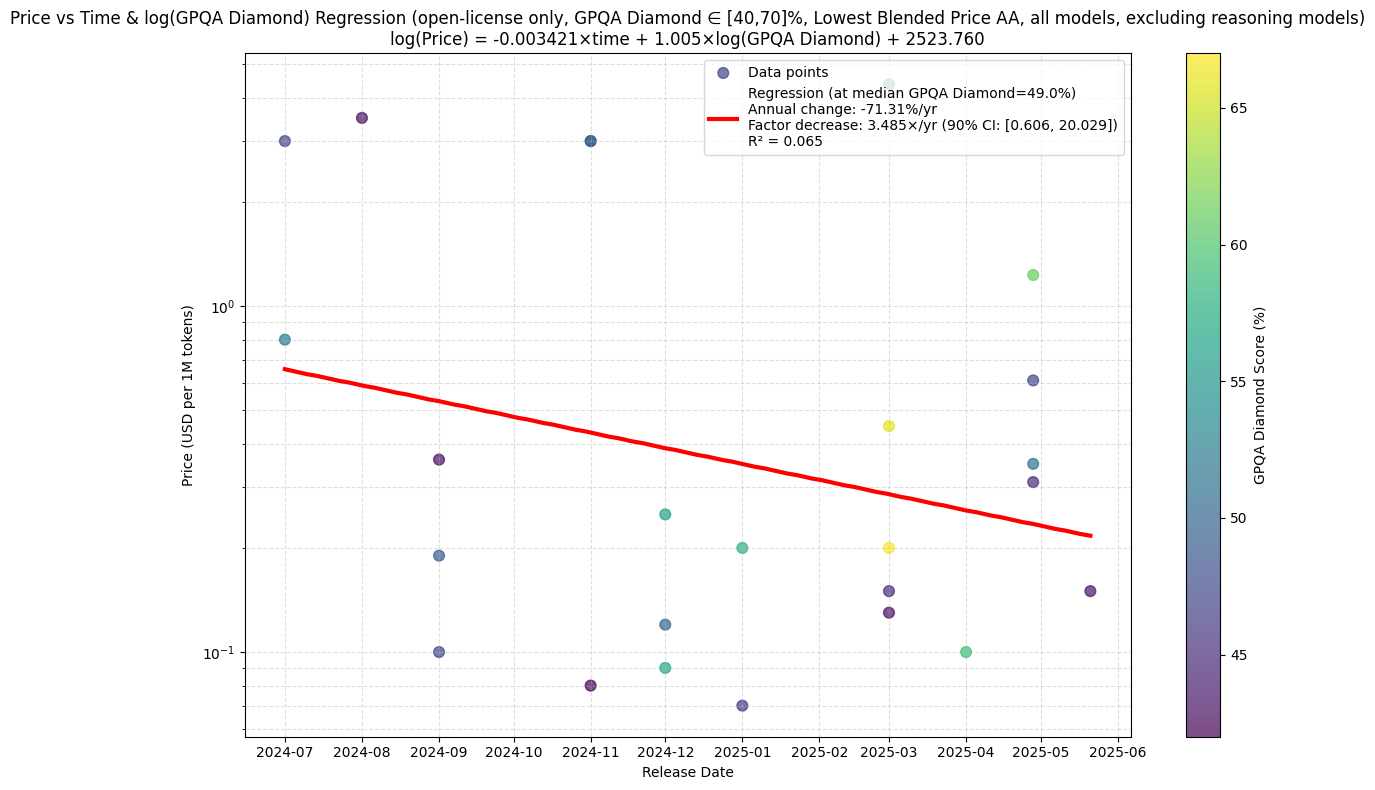


Regression Results:
Model: log(Price) = -0.003421×time + 1.005×log(GPQA Diamond) + 2523.760
R² score: 0.0652

Time coefficient (alpha): -0.003421
Annual percentage change: -71.31%/yr
Annual factor decrease: 3.485×/yr
90% CI for factor decrease: [0.606, 20.029]
log(GPQA Diamond) coefficient (beta): 1.005
Intercept (c): 2523.760

Data points used: 25


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
from scipy import stats

def plot_price_mmlu_regression(df, open_license_only=False, min_mmlu=40, max_mmlu=70, price_column='Output Price\nUSD/1M Tokens', exclude_dominated=False, benchmark_col='MMLU-Pro (Reasoning & Knowledge)', exclude_reasoning=False):
    """
    Plot log(Price) = alpha*time + beta*log(MMLU Pro) + c regression
    
    Parameters:
    - df: DataFrame with the model data
    - open_license_only: If True, only include models with open licenses
    - min_mmlu: Minimum MMLU score to include (default: 40)
    - max_mmlu: Maximum MMLU score to include (default: 70)
    - price_column: Column name for price data (default: 'Output Price\nUSD/1M Tokens')
    - exclude_dominated: If True, exclude models that are Pareto dominated by earlier models
    - benchmark_col: Column name for benchmark data (default: 'MMLU-Pro (Reasoning & Knowledge)')
    - exclude_reasoning: If True, exclude models with Reasoning_TF = True
    
    Returns fitted model coefficients and annual decrease rates
    """
    # Column names
    mmlu_col = benchmark_col
    price_col = price_column
    license_col = 'License'
    reasoning_col = 'Reasoning_TF'
    
    # Work on a copy
    df_work = df.copy()
    
    # 1) Convert MMLU "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%', '', regex=False)
                         .astype(float)
    )
    
    # 2) Convert price "$X,XXX" → float
    df_work[price_col] = (
        df_work[price_col].astype(str)
                         .str.replace('[$,]', '', regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    
    # 3) Optionally filter to open-license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]
    
    # 4) Optionally filter out reasoning models
    if exclude_reasoning and reasoning_col in df_work.columns:
        df_work = df_work[df_work[reasoning_col] != True]
    
    # 5) Filter to rows with all necessary data
    df_sub = df_work.dropna(subset=['Release Date', price_col, mmlu_col])
    df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[mmlu_col] > 0)]
    
    # 6) Filter by MMLU range
    df_sub = df_sub[(df_sub[mmlu_col] >= min_mmlu) & (df_sub[mmlu_col] <= max_mmlu)]
    
    # 7) Optionally filter out Pareto dominated models
    if exclude_dominated:
        df_sub = df_sub.sort_values('Release Date')
        non_dominated = []
        
        for i, row in df_sub.iterrows():
            # Check if this model is dominated by any previous model
            dominated = False
            for j in non_dominated:
                prev_row = df_sub.loc[j]
                # A model is dominated if there exists a previous model with:
                # 1. Better or equal MMLU score AND
                # 2. Lower or equal price
                if (prev_row[mmlu_col] >= row[mmlu_col] and 
                    prev_row[price_col] <= row[price_col] and
                    (prev_row[mmlu_col] > row[mmlu_col] or prev_row[price_col] < row[price_col])):
                    dominated = True
                    break
            
            if not dominated:
                non_dominated.append(i)
                
                # Also remove any previously added models that this one dominates
                new_non_dominated = []
                for j in non_dominated[:-1]:  # All except the one we just added
                    prev_row = df_sub.loc[j]
                    if not (row[mmlu_col] >= prev_row[mmlu_col] and 
                           row[price_col] <= prev_row[price_col] and
                           (row[mmlu_col] > prev_row[mmlu_col] or row[price_col] < prev_row[price_col])):
                        new_non_dominated.append(j)
                
                non_dominated = new_non_dominated + [i]
        
        df_sub = df_sub.loc[non_dominated]
    
    if len(df_sub) < 3:
        print(f"Warning: Only {len(df_sub)} data points available. Need at least 3 for regression.")
        return None, None, None
    
    # 8) Prepare variables for regression
    df_sub = df_sub.sort_values('Release Date').copy()
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
    
    # Features: time and log(MMLU)
    X = np.column_stack([
        df_sub['Date_Ordinal'].values,
        np.log(df_sub[mmlu_col].values)
    ])
    
    # Target: log(Price)
    y = np.log(df_sub[price_col].values)
    
    # 9) Fit linear regression
    model = LinearRegression().fit(X, y)
    alpha, beta = model.coef_
    c = model.intercept_
    r2 = model.score(X, y)
    
    # 10) Calculate annual decrease rates
    # alpha is change in log(price) per day, so annual change is alpha * 365
    annual_log_change = alpha * 365
    annual_pct_change = (np.exp(annual_log_change) - 1) * 100
    factor_change_per_year = np.exp(annual_log_change)
    
    # Express as factor decrease if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_per_year = 1 / factor_change_per_year
    else:
        factor_decrease_per_year = None
    
    # 11) Calculate confidence intervals for the time coefficient
    n = len(df_sub)
    p = 2  # number of predictors (time and log(MMLU))
    y_pred = model.predict(X)
    residuals = y - y_pred
    mse = np.sum(residuals**2) / (n - p - 1)
    
    # Calculate variance-covariance matrix
    X_mean_centered = X - np.mean(X, axis=0)
    cov_matrix = np.linalg.inv(X_mean_centered.T.dot(X_mean_centered)) * mse
    
    # Standard error for alpha (time coefficient)
    se_alpha = np.sqrt(cov_matrix[0, 0])
    se_annual = se_alpha * 365  # Standard error for annual coefficient
    
    # t-statistic for 90% confidence interval
    t_stat = stats.t.ppf(0.95, n - p - 1)
    
    # Confidence interval for annual log change
    annual_log_change_lower = annual_log_change - t_stat * se_annual
    annual_log_change_upper = annual_log_change + t_stat * se_annual
    
    # Convert to factor change confidence interval
    factor_change_lower = np.exp(annual_log_change_lower)
    factor_change_upper = np.exp(annual_log_change_upper)
    
    # Express as factor decrease for confidence interval if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_lower = 1 / factor_change_upper
        factor_decrease_upper = 1 / factor_change_lower
    else:
        factor_decrease_lower = None
        factor_decrease_upper = None
    
    # 12) Generate predictions for plotting
    min_ord, max_ord = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range = np.linspace(min_ord, max_ord, 100)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]
    
    # For visualization, we'll show the trend at median MMLU value
    median_mmlu = df_sub[mmlu_col].median()
    X_pred = np.column_stack([
        x_range,
        np.full(len(x_range), np.log(median_mmlu))
    ])
    y_pred = model.predict(X_pred)
    
    # 13) Plot results
    plt.figure(figsize=(12, 8))
    
    # Color points by MMLU score for better visualization
    scatter = plt.scatter(
        df_sub['Release Date'], 
        df_sub[price_col],
        c=df_sub[mmlu_col], 
        cmap='viridis', 
        alpha=0.7,
        s=60,
        label='Data points'
    )
    
    # Add colorbar for MMLU scores
    cbar = plt.colorbar(scatter)
    benchmark_name = benchmark_col.split(' (')[0]  # Extract the main part of the benchmark name
    cbar.set_label(f'{benchmark_name} Score (%)')
    
    # Plot regression line (at median MMLU)
    if factor_decrease_per_year:
        regression_label = (f'Regression (at median {benchmark_name}={median_mmlu:.1f}%)\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor decrease: {factor_decrease_per_year:.3f}×/yr (90% CI: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}])\n'
                           f'R² = {r2:.3f}')
    else:
        regression_label = (f'Regression (at median {benchmark_name}={median_mmlu:.1f}%)\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor change: {factor_change_per_year:.3f}×/yr (90% CI: [{factor_change_lower:.3f}, {factor_change_upper:.3f}])\n'
                           f'R² = {r2:.3f}')
    
    plt.plot(x_dates, np.exp(y_pred), 'r-', lw=3, label=regression_label)
    
    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Price (USD per 1M tokens)')
    
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    mmlu_range = f"{benchmark_name} ∈ [{min_mmlu},{max_mmlu}]%"
    price_type = price_col.replace('\n', ' ')
    pareto_label = "non-dominated models only" if exclude_dominated else "all models"
    reasoning_label = "excluding reasoning models" if exclude_reasoning else "including reasoning models"
    plt.title(f'Price vs Time & log({benchmark_name}) Regression ({lic_label}, {mmlu_range}, {price_type}, {pareto_label}, {reasoning_label})\n'
              f'log(Price) = {alpha:.6f}×time + {beta:.3f}×log({benchmark_name}) + {c:.3f}')
    
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\nRegression Results:")
    print(f"Model: log(Price) = {alpha:.6f}×time + {beta:.3f}×log({benchmark_name}) + {c:.3f}")
    print(f"R² score: {r2:.4f}")
    print(f"\nTime coefficient (alpha): {alpha:.6f}")
    print(f"Annual percentage change: {annual_pct_change:.2f}%/yr")
    
    if factor_decrease_per_year:
        print(f"Annual factor decrease: {factor_decrease_per_year:.3f}×/yr")
        print(f"90% CI for factor decrease: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}]")
    else:
        print(f"Annual factor change: {factor_change_per_year:.3f}×/yr")
        print(f"90% CI for factor change: [{factor_change_lower:.3f}, {factor_change_upper:.3f}]")
    
    print(f"log({benchmark_name}) coefficient (beta): {beta:.3f}")
    print(f"Intercept (c): {c:.3f}")
    print(f"\nData points used: {len(df_sub)}")
    
    return model, df_sub, {
        'alpha': alpha,
        'beta': beta, 
        'c': c,
        'annual_pct_change': annual_pct_change,
        'factor_change_per_year': factor_change_per_year,
        'factor_decrease_per_year': factor_decrease_per_year if factor_change_per_year < 1 else None,
        'factor_change_ci_lower': factor_change_lower,
        'factor_change_ci_upper': factor_change_upper,
        'factor_decrease_ci_lower': factor_decrease_lower if factor_change_per_year < 1 else None,
        'factor_decrease_ci_upper': factor_decrease_upper if factor_change_per_year < 1 else None,
        'r2_score': r2
    }

# Index(['Model', 'Creator', 'License', 'Context\nWindow',
#        'Artificial Analysis\nIntelligence Index',
#        'MMLU-Pro (Reasoning & Knowledge)',
#        'GPQA Diamond (Scientific Reasoning)',
#        'Humanity's Last Exam (Reasoning & Knowledge)',
#        'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
#        'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
#        'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
#        'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
#        'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
#        'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
#        'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
#        'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
#        'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
#        'Further\nAnalysis', 'Release Date', 'Parameters',
#        'Known Active Parameters', 'Lowest Output Price Found AA',
#        'Lowest Input Price AA', 'Lowest Blended Price AA', 'Latency',
#        'token/s', 'Chinese', 'Notes', 'input_tokens_epoch_gpqa',
#        'outpur_tokens_epoch_gpqa', 'epoch_gpqa', 'price input lowest',
#        'price output lowest', 'total price lowest'],
#       dtype='object')


# Lowest Output Price Found AA
# Lowest Input Price AA

    # benchmark1_col="MMLU-Pro (Reasoning & Knowledge)", 
    # benchmark2_col="GPQA Diamond (Scientific Reasoning)",
    # benchmark3_col="LiveCodeBench (Coding)",

# Example usage:
# Assuming df is loaded with your data
# model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Output Price Found AA", exclude_dominated=False)
# model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Input Price AA", exclude_dominated=False)
model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Blended Price AA", 
exclude_dominated=False, benchmark_col="GPQA Diamond (Scientific Reasoning)", min_mmlu=40, max_mmlu=70, exclude_reasoning=True)

## More Regressors

### testing model with 2 different regressors

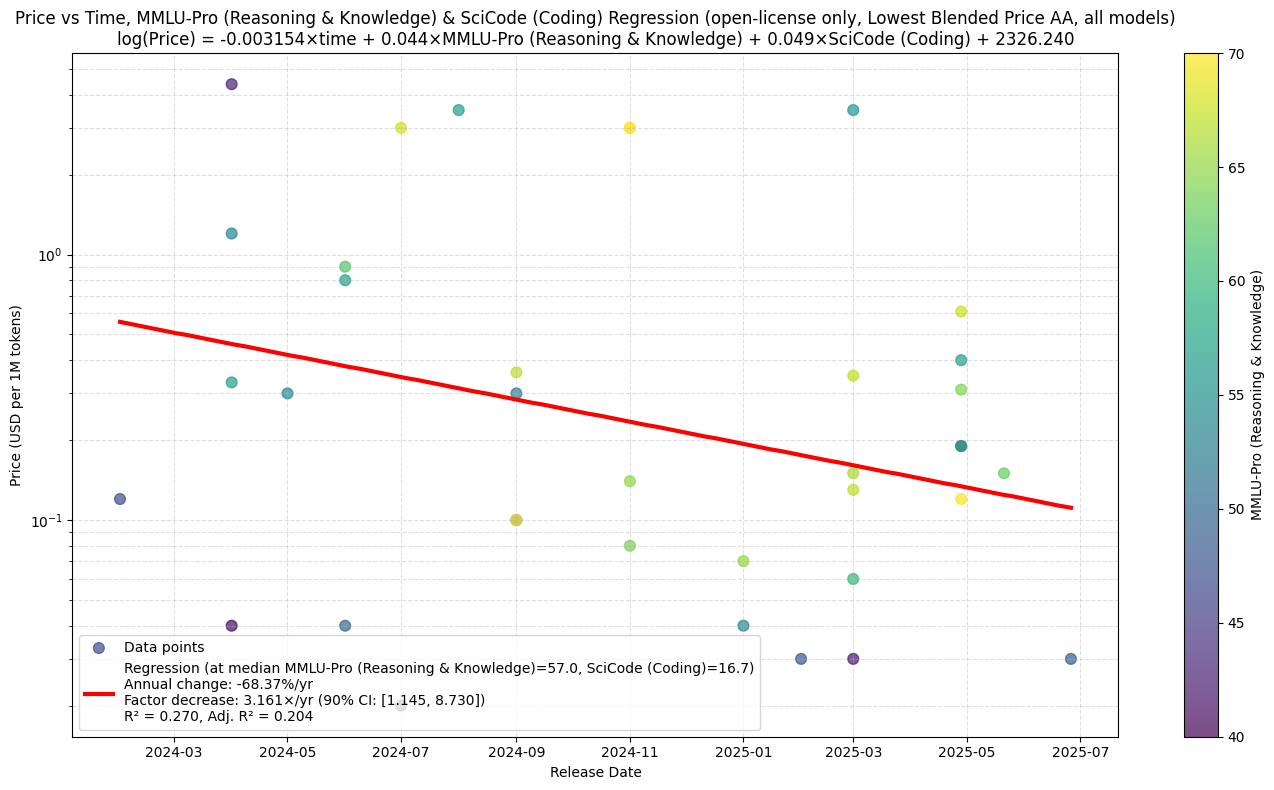


Regression Results:
Model: log(Price) = -0.003154×time + 0.044×MMLU-Pro (Reasoning & Knowledge) + 0.049×SciCode (Coding) + 2326.240
R² score: 0.2704
Adjusted R² score: 0.2040

Time coefficient (alpha): -0.003154
Annual percentage change: -68.37%/yr
Annual factor decrease: 3.161×/yr
90% CI for factor decrease: [1.145, 8.730]
MMLU-Pro (Reasoning & Knowledge) coefficient (beta): 0.044
SciCode (Coding) coefficient (gamma): 0.049
Intercept (c): 2326.240

Data points used: 37


In [ ]:
def plot_price_benchmark_regression(df, benchmark1_col, benchmark2_col, open_license_only=False, 
                                  min_benchmark1=None, max_benchmark1=None, 
                                  price_column='Output Price\nUSD/1M Tokens', 
                                  exclude_dominated=False):
    """
    Plot log(Price) = alpha*time + beta*benchmark1 + gamma*benchmark2 + c regression
    
    Parameters:
    - df: DataFrame with the model data
    - benchmark1_col: Name of the first benchmark column to use
    - benchmark2_col: Name of the second benchmark column to use
    - open_license_only: If True, only include models with open licenses
    - min_benchmark1: Minimum score for first benchmark to include (optional)
    - max_benchmark1: Maximum score for first benchmark to include (optional)
    - price_column: Column name for price data (default: 'Output Price\nUSD/1M Tokens')
    - exclude_dominated: If True, exclude models that are Pareto dominated by earlier models
    
    Returns fitted model coefficients and annual decrease rates
    """
    # Column names
    price_col = price_column
    license_col = 'License'
    
    # Work on a copy
    df_work = df.copy()
    
    # Convert benchmark columns to numeric if they're in percentage format
    for col in [benchmark1_col, benchmark2_col]:
        if col in df_work.columns:
            # Handle percentage format
            if df_work[col].dtype == 'object':
                df_work[col] = (
                    df_work[col].astype(str)
                                 .str.replace('%', '', regex=False)
                                 .str.replace(',', '', regex=False)
                )
            df_work[col] = pd.to_numeric(df_work[col], errors='coerce')
    
    # Convert price "$X,XXX" → float
    if df_work[price_col].dtype == 'object':
        df_work[price_col] = (
            df_work[price_col].astype(str)
                             .str.replace('[$,]', '', regex=True)
        )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    
    # Optionally filter to open-license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]
    
    # Filter to rows with all necessary data
    required_cols = ['Release Date', price_col, benchmark1_col, benchmark2_col]
    df_sub = df_work.dropna(subset=required_cols)
    df_sub = df_sub[(df_sub[price_col] > 0) & 
                    (df_sub[benchmark1_col] > 0) & 
                    (df_sub[benchmark2_col] > 0)]
    
    # Filter by benchmark1 range if specified
    if min_benchmark1 is not None:
        df_sub = df_sub[df_sub[benchmark1_col] >= min_benchmark1]
    if max_benchmark1 is not None:
        df_sub = df_sub[df_sub[benchmark1_col] <= max_benchmark1]
    
    # Optionally filter out Pareto dominated models
    if exclude_dominated:
        df_sub = df_sub.sort_values('Release Date')
        non_dominated = []
        
        for i, row in df_sub.iterrows():
            # Check if this model is dominated by any previous model
            dominated = False
            for j in non_dominated:
                prev_row = df_sub.loc[j]
                # A model is dominated if there exists a previous model with:
                # 1. Better or equal benchmark scores AND
                # 2. Lower or equal price
                if (prev_row[benchmark1_col] >= row[benchmark1_col] and 
                    prev_row[benchmark2_col] >= row[benchmark2_col] and
                    prev_row[price_col] <= row[price_col] and
                    (prev_row[benchmark1_col] > row[benchmark1_col] or 
                     prev_row[benchmark2_col] > row[benchmark2_col] or 
                     prev_row[price_col] < row[price_col])):
                    dominated = True
                    break
            
            if not dominated:
                non_dominated.append(i)
                
                # Also remove any previously added models that this one dominates
                new_non_dominated = []
                for j in non_dominated[:-1]:  # All except the one we just added
                    prev_row = df_sub.loc[j]
                    if not (row[benchmark1_col] >= prev_row[benchmark1_col] and 
                           row[benchmark2_col] >= prev_row[benchmark2_col] and
                           row[price_col] <= prev_row[price_col] and
                           (row[benchmark1_col] > prev_row[benchmark1_col] or 
                            row[benchmark2_col] > prev_row[benchmark2_col] or 
                            row[price_col] < prev_row[price_col])):
                        new_non_dominated.append(j)
                
                non_dominated = new_non_dominated + [i]
        
        df_sub = df_sub.loc[non_dominated]
    
    if len(df_sub) < 4:  # Need at least 4 points for 3 predictors + intercept
        print(f"Warning: Only {len(df_sub)} data points available. Need at least 4 for regression with 2 benchmarks.")
        return None, None, None
    
    # Prepare variables for regression
    df_sub = df_sub.sort_values('Release Date').copy()
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
    
    # Features: time, benchmark1, benchmark2
    X = np.column_stack([
        df_sub['Date_Ordinal'].values,
        df_sub[benchmark1_col].values,
        df_sub[benchmark2_col].values
    ])
    
    # Target: log(Price)
    y = np.log(df_sub[price_col].values)
    
    # Fit linear regression
    model = LinearRegression().fit(X, y)
    alpha, beta, gamma = model.coef_
    c = model.intercept_
    r2 = model.score(X, y)
    
    # Calculate adjusted R²
    n = len(df_sub)
    p = 3  # number of predictors
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # Calculate annual decrease rates
    annual_log_change = alpha * 365
    annual_pct_change = (np.exp(annual_log_change) - 1) * 100
    factor_change_per_year = np.exp(annual_log_change)
    
    # Express as factor decrease if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_per_year = 1 / factor_change_per_year
    else:
        factor_decrease_per_year = None
    
    # Calculate confidence intervals for the time coefficient
    y_pred = model.predict(X)
    residuals = y - y_pred
    mse = np.sum(residuals**2) / (n - p - 1)
    
    # Calculate variance-covariance matrix
    X_mean_centered = X - np.mean(X, axis=0)
    cov_matrix = np.linalg.inv(X_mean_centered.T.dot(X_mean_centered)) * mse
    
    # Standard error for alpha (time coefficient)
    se_alpha = np.sqrt(cov_matrix[0, 0])
    se_annual = se_alpha * 365
    
    # t-statistic for 90% confidence interval
    t_stat = stats.t.ppf(0.95, n - p - 1)
    
    # Confidence interval for annual log change
    annual_log_change_lower = annual_log_change - t_stat * se_annual
    annual_log_change_upper = annual_log_change + t_stat * se_annual
    
    # Convert to factor change confidence interval
    factor_change_lower = np.exp(annual_log_change_lower)
    factor_change_upper = np.exp(annual_log_change_upper)
    
    # Express as factor decrease for confidence interval if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_lower = 1 / factor_change_upper
        factor_decrease_upper = 1 / factor_change_lower
    else:
        factor_decrease_lower = None
        factor_decrease_upper = None
    
    # Generate predictions for plotting
    min_ord, max_ord = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range = np.linspace(min_ord, max_ord, 100)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]
    
    # For visualization, show trend at median values
    median_benchmark1 = df_sub[benchmark1_col].median()
    median_benchmark2 = df_sub[benchmark2_col].median()
    
    X_pred = np.column_stack([
        x_range,
        np.full(len(x_range), median_benchmark1),
        np.full(len(x_range), median_benchmark2)
    ])
    y_pred = model.predict(X_pred)
    
    # Plot results
    plt.figure(figsize=(14, 8))
    
    # Color points by first benchmark score
    scatter = plt.scatter(
        df_sub['Release Date'], 
        df_sub[price_col],
        c=df_sub[benchmark1_col], 
        cmap='viridis', 
        alpha=0.7,
        s=60,
        label='Data points'
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label(f'{benchmark1_col}')
    
    # Plot regression line (at median values)
    if factor_decrease_per_year:
        regression_label = (f'Regression (at median {benchmark1_col}={median_benchmark1:.1f}, {benchmark2_col}={median_benchmark2:.1f})\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor decrease: {factor_decrease_per_year:.3f}×/yr (90% CI: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}])\n'
                           f'R² = {r2:.3f}, Adj. R² = {adjusted_r2:.3f}')
    else:
        regression_label = (f'Regression (at median {benchmark1_col}={median_benchmark1:.1f}, {benchmark2_col}={median_benchmark2:.1f})\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor change: {factor_change_per_year:.3f}×/yr (90% CI: [{factor_change_lower:.3f}, {factor_change_upper:.3f}])\n'
                           f'R² = {r2:.3f}, Adj. R² = {adjusted_r2:.3f}')
    
    plt.plot(x_dates, np.exp(y_pred), 'r-', lw=3, label=regression_label)
    
    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Price (USD per 1M tokens)')
    
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    price_type = price_column.replace('\n', ' ')
    pareto_label = "non-dominated models only" if exclude_dominated else "all models"
    
    plt.title(f'Price vs Time, {benchmark1_col} & {benchmark2_col} Regression ({lic_label}, {price_type}, {pareto_label})\n'
              f'log(Price) = {alpha:.6f}×time + {beta:.3f}×{benchmark1_col} + {gamma:.3f}×{benchmark2_col} + {c:.3f}')
    
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\nRegression Results:")
    print(f"Model: log(Price) = {alpha:.6f}×time + {beta:.3f}×{benchmark1_col} + {gamma:.3f}×{benchmark2_col} + {c:.3f}")
    print(f"R² score: {r2:.4f}")
    print(f"Adjusted R² score: {adjusted_r2:.4f}")
    print(f"\nTime coefficient (alpha): {alpha:.6f}")
    print(f"Annual percentage change: {annual_pct_change:.2f}%/yr")
    
    if factor_decrease_per_year:
        print(f"Annual factor decrease: {factor_decrease_per_year:.3f}×/yr")
        print(f"90% CI for factor decrease: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}]")
    else:
        print(f"Annual factor change: {factor_change_per_year:.3f}×/yr")
        print(f"90% CI for factor change: [{factor_change_lower:.3f}, {factor_change_upper:.3f}]")
    
    print(f"{benchmark1_col} coefficient (beta): {beta:.3f}")
    print(f"{benchmark2_col} coefficient (gamma): {gamma:.3f}")
    print(f"Intercept (c): {c:.3f}")
    print(f"\nData points used: {len(df_sub)}")
    
    return model, df_sub, {
        'alpha': alpha,
        'beta': beta,
        'gamma': gamma,
        'c': c,
        'annual_pct_change': annual_pct_change,
        'factor_change_per_year': factor_change_per_year,
        'factor_decrease_per_year': factor_decrease_per_year if factor_change_per_year < 1 else None,
        'factor_change_ci_lower': factor_change_lower,
        'factor_change_ci_upper': factor_change_upper,
        'factor_decrease_ci_lower': factor_decrease_lower if factor_change_per_year < 1 else None,
        'factor_decrease_ci_upper': factor_decrease_upper if factor_change_per_year < 1 else None,
        'r2_score': r2,
        'adjusted_r2_score': adjusted_r2
    }

# Example usage:
model, data, results = plot_price_benchmark_regression(
    df, 
    benchmark1_col="MMLU-Pro (Reasoning & Knowledge)", 
    benchmark2_col="SciCode (Coding)",
    min_benchmark1=40,
    max_benchmark1=70,
    open_license_only=True, 
    price_column="Lowest Blended Price AA", 
    exclude_dominated=False
)


# Index(['Model', 'Creator', 'License', 'Context\nWindow',
#        'Artificial Analysis\nIntelligence Index',
#        'MMLU-Pro (Reasoning & Knowledge)',
#        'GPQA Diamond (Scientific Reasoning)',
#        'Humanity's Last Exam (Reasoning & Knowledge)',
#        'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
#        'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
#        'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
#        'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
#        'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
#        'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
#        'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
#        'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
#        'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
#        'Further\nAnalysis', 'Release Date', 'Parameters',
#        'Known Active Parameters', 'Lowest Output Price Found AA',
#        'Lowest Input Price AA', 'Lowest Blended Price AA', 'Latency',
#        'token/s', 'Chinese', 'Notes', 'input_tokens_epoch_gpqa',
#        'outpur_tokens_epoch_gpqa', 'epoch_gpqa', 'price input lowest',
#        'price output lowest', 'total price lowest'],
#       dtype='object')

## Massive Regression

###  testing fit with 4 different regressors

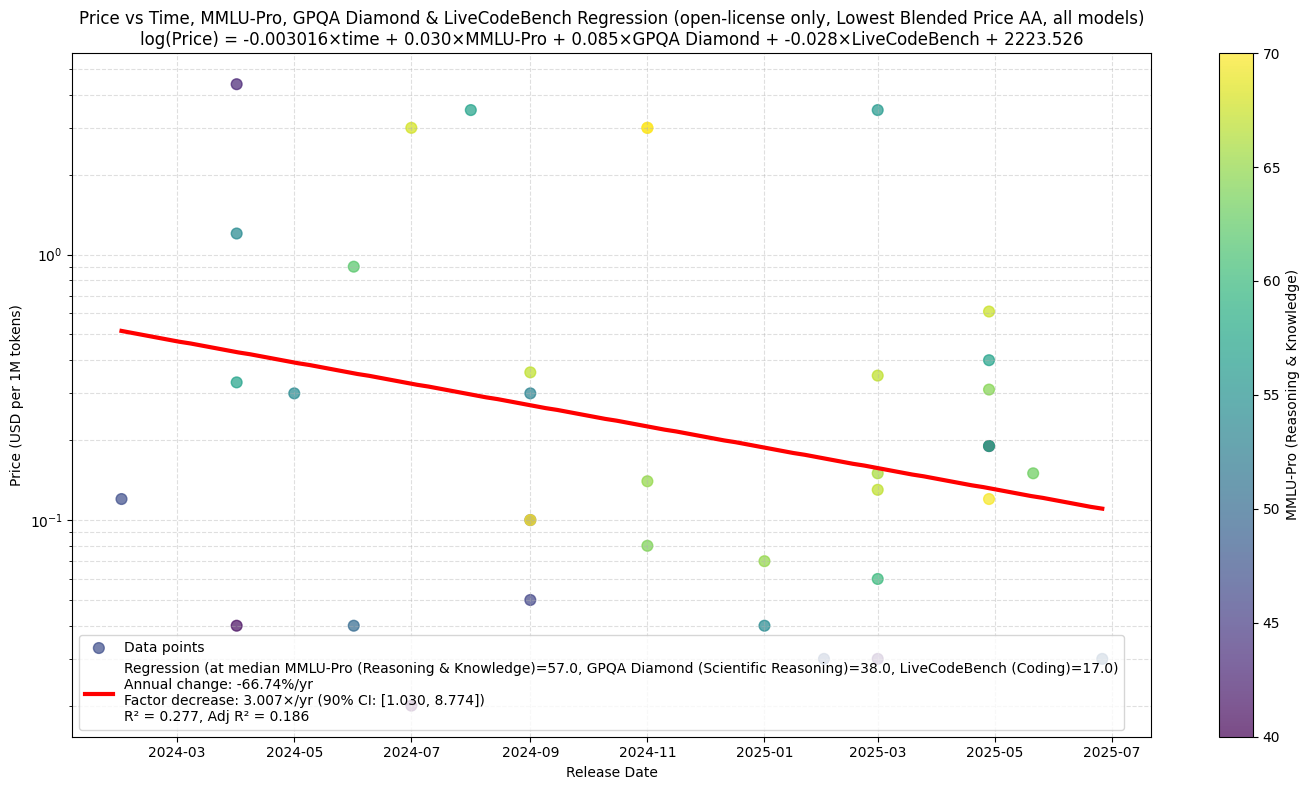


Regression Results:
Model: log(Price) = -0.003016×time + 0.030×MMLU-Pro (Reasoning & Knowledge) + 0.085×GPQA Diamond (Scientific Reasoning) + -0.028×LiveCodeBench (Coding) + 2223.526
R² score: 0.2766
Adjusted R² score: 0.1862

Time coefficient (alpha): -0.003016
Annual percentage change: -66.74%/yr
Annual factor decrease: 3.007×/yr
90% CI for factor decrease: [1.030, 8.774]
MMLU-Pro (Reasoning & Knowledge) coefficient (beta): 0.030
GPQA Diamond (Scientific Reasoning) coefficient (gamma): 0.085
LiveCodeBench (Coding) coefficient (delta): -0.028
Intercept (c): 2223.526

Data points used: 37


In [ ]:
def plot_price_three_benchmark_regression(df, benchmark1_col, benchmark2_col, benchmark3_col, 
                                        open_license_only=False, 
                                        min_benchmark1=None, max_benchmark1=None,
                                        min_benchmark2=None, max_benchmark2=None,
                                        min_benchmark3=None, max_benchmark3=None,
                                        price_column='Output Price\nUSD/1M Tokens', 
                                        exclude_dominated=False):
    """
    Plot log(Price) = alpha*time + beta*benchmark1 + gamma*benchmark2 + delta*benchmark3 + c regression
    
    Parameters:
    - df: DataFrame with the model data
    - benchmark1_col: Name of the first benchmark column to use
    - benchmark2_col: Name of the second benchmark column to use
    - benchmark3_col: Name of the third benchmark column to use
    - open_license_only: If True, only include models with open licenses
    - min_benchmark1, max_benchmark1: Min/max scores for first benchmark (optional)
    - min_benchmark2, max_benchmark2: Min/max scores for second benchmark (optional)
    - min_benchmark3, max_benchmark3: Min/max scores for third benchmark (optional)
    - price_column: Column name for price data (default: 'Output Price\nUSD/1M Tokens')
    - exclude_dominated: If True, exclude models that are Pareto dominated by earlier models
    
    Returns fitted model coefficients and annual decrease rates
    """
    # Column names
    price_col = price_column
    license_col = 'License'
    
    # Work on a copy
    df_work = df.copy()
    
    # Convert benchmark columns to numeric if they're in percentage format
    for col in [benchmark1_col, benchmark2_col, benchmark3_col]:
        if col in df_work.columns:
            # Handle percentage format
            if df_work[col].dtype == 'object':
                df_work[col] = (
                    df_work[col].astype(str)
                                 .str.replace('%', '', regex=False)
                                 .str.replace(',', '', regex=False)
                )
            df_work[col] = pd.to_numeric(df_work[col], errors='coerce')
    
    # Convert price "$X,XXX" → float
    if df_work[price_col].dtype == 'object':
        df_work[price_col] = (
            df_work[price_col].astype(str)
                             .str.replace('[$,]', '', regex=True)
        )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    
    # Optionally filter to open-license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]
    
    # Filter to rows with all necessary data
    required_cols = ['Release Date', price_col, benchmark1_col, benchmark2_col, benchmark3_col]
    df_sub = df_work.dropna(subset=required_cols)
    df_sub = df_sub[(df_sub[price_col] > 0) & 
                    (df_sub[benchmark1_col] > 0) & 
                    (df_sub[benchmark2_col] > 0) &
                    (df_sub[benchmark3_col] > 0)]
    
    # Filter by benchmark ranges if specified
    if min_benchmark1 is not None:
        df_sub = df_sub[df_sub[benchmark1_col] >= min_benchmark1]
    if max_benchmark1 is not None:
        df_sub = df_sub[df_sub[benchmark1_col] <= max_benchmark1]
    
    if min_benchmark2 is not None:
        df_sub = df_sub[df_sub[benchmark2_col] >= min_benchmark2]
    if max_benchmark2 is not None:
        df_sub = df_sub[df_sub[benchmark2_col] <= max_benchmark2]
        
    if min_benchmark3 is not None:
        df_sub = df_sub[df_sub[benchmark3_col] >= min_benchmark3]
    if max_benchmark3 is not None:
        df_sub = df_sub[df_sub[benchmark3_col] <= max_benchmark3]
    
    # Optionally filter out Pareto dominated models
    if exclude_dominated:
        df_sub = df_sub.sort_values('Release Date')
        non_dominated = []
        
        for i, row in df_sub.iterrows():
            # Check if this model is dominated by any previous model
            dominated = False
            for j in non_dominated:
                prev_row = df_sub.loc[j]
                # A model is dominated if there exists a previous model with:
                # 1. Better or equal benchmark scores AND
                # 2. Lower or equal price
                if (prev_row[benchmark1_col] >= row[benchmark1_col] and 
                    prev_row[benchmark2_col] >= row[benchmark2_col] and
                    prev_row[benchmark3_col] >= row[benchmark3_col] and
                    prev_row[price_col] <= row[price_col] and
                    (prev_row[benchmark1_col] > row[benchmark1_col] or 
                     prev_row[benchmark2_col] > row[benchmark2_col] or 
                     prev_row[benchmark3_col] > row[benchmark3_col] or 
                     prev_row[price_col] < row[price_col])):
                    dominated = True
                    break
            
            if not dominated:
                non_dominated.append(i)
                
                # Also remove any previously added models that this one dominates
                new_non_dominated = []
                for j in non_dominated[:-1]:  # All except the one we just added
                    prev_row = df_sub.loc[j]
                    if not (row[benchmark1_col] >= prev_row[benchmark1_col] and 
                           row[benchmark2_col] >= prev_row[benchmark2_col] and
                           row[benchmark3_col] >= prev_row[benchmark3_col] and
                           row[price_col] <= prev_row[price_col] and
                           (row[benchmark1_col] > prev_row[benchmark1_col] or 
                            row[benchmark2_col] > prev_row[benchmark2_col] or 
                            row[benchmark3_col] > prev_row[benchmark3_col] or 
                            row[price_col] < prev_row[price_col])):
                        new_non_dominated.append(j)
                
                non_dominated = new_non_dominated + [i]
        
        df_sub = df_sub.loc[non_dominated]
    
    if len(df_sub) < 5:  # Need at least 5 points for 4 predictors + intercept
        print(f"Warning: Only {len(df_sub)} data points available. Need at least 5 for regression with 3 benchmarks.")
        return None, None, None
    
    # Prepare variables for regression
    df_sub = df_sub.sort_values('Release Date').copy()
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
    
    # Features: time, benchmark1, benchmark2, benchmark3
    X = np.column_stack([
        df_sub['Date_Ordinal'].values,
        df_sub[benchmark1_col].values,
        df_sub[benchmark2_col].values,
        df_sub[benchmark3_col].values
    ])
    
    # Target: log(Price)
    y = np.log(df_sub[price_col].values)
    
    # Fit linear regression
    model = LinearRegression().fit(X, y)
    alpha, beta, gamma, delta = model.coef_
    c = model.intercept_
    r2 = model.score(X, y)
    
    # Calculate adjusted R²
    n = len(df_sub)
    p = 4  # number of predictors (time + 3 benchmarks)
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # Calculate annual decrease rates
    annual_log_change = alpha * 365
    annual_pct_change = (np.exp(annual_log_change) - 1) * 100
    factor_change_per_year = np.exp(annual_log_change)
    
    # Express as factor decrease if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_per_year = 1 / factor_change_per_year
    else:
        factor_decrease_per_year = None
    
    # Calculate confidence intervals for the time coefficient
    y_pred = model.predict(X)
    residuals = y - y_pred
    mse = np.sum(residuals**2) / (n - p - 1)
    
    # Calculate variance-covariance matrix
    X_mean_centered = X - np.mean(X, axis=0)
    cov_matrix = np.linalg.inv(X_mean_centered.T.dot(X_mean_centered)) * mse
    
    # Standard error for alpha (time coefficient)
    se_alpha = np.sqrt(cov_matrix[0, 0])
    se_annual = se_alpha * 365
    
    # t-statistic for 90% confidence interval
    t_stat = stats.t.ppf(0.95, n - p - 1)
    
    # Confidence interval for annual log change
    annual_log_change_lower = annual_log_change - t_stat * se_annual
    annual_log_change_upper = annual_log_change + t_stat * se_annual
    
    # Convert to factor change confidence interval
    factor_change_lower = np.exp(annual_log_change_lower)
    factor_change_upper = np.exp(annual_log_change_upper)
    
    # Express as factor decrease for confidence interval if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_lower = 1 / factor_change_upper
        factor_decrease_upper = 1 / factor_change_lower
    else:
        factor_decrease_lower = None
        factor_decrease_upper = None
    
    # Generate predictions for plotting
    min_ord, max_ord = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range = np.linspace(min_ord, max_ord, 100)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]
    
    # For visualization, show trend at median values
    median_benchmark1 = df_sub[benchmark1_col].median()
    median_benchmark2 = df_sub[benchmark2_col].median()
    median_benchmark3 = df_sub[benchmark3_col].median()
    
    X_pred = np.column_stack([
        x_range,
        np.full(len(x_range), median_benchmark1),
        np.full(len(x_range), median_benchmark2),
        np.full(len(x_range), median_benchmark3)
    ])
    y_pred = model.predict(X_pred)
    
    # Plot results
    plt.figure(figsize=(15, 8))
    
    # Color points by first benchmark score
    scatter = plt.scatter(
        df_sub['Release Date'], 
        df_sub[price_col],
        c=df_sub[benchmark1_col], 
        cmap='viridis', 
        alpha=0.7,
        s=60,
        label='Data points'
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label(f'{benchmark1_col}')
    
    # Plot regression line (at median values)
    if factor_decrease_per_year:
        regression_label = (f'Regression (at median {benchmark1_col}={median_benchmark1:.1f}, {benchmark2_col}={median_benchmark2:.1f}, {benchmark3_col}={median_benchmark3:.1f})\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor decrease: {factor_decrease_per_year:.3f}×/yr (90% CI: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}])\n'
                           f'R² = {r2:.3f}, Adj R² = {r2_adj:.3f}')
    else:
        regression_label = (f'Regression (at median {benchmark1_col}={median_benchmark1:.1f}, {benchmark2_col}={median_benchmark2:.1f}, {benchmark3_col}={median_benchmark3:.1f})\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor change: {factor_change_per_year:.3f}×/yr (90% CI: [{factor_change_lower:.3f}, {factor_change_upper:.3f}])\n'
                           f'R² = {r2:.3f}, Adj R² = {r2_adj:.3f}')
    
    plt.plot(x_dates, np.exp(y_pred), 'r-', lw=3, label=regression_label)
    
    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Price (USD per 1M tokens)')
    
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    price_type = price_column.replace('\n', ' ')
    pareto_label = "non-dominated models only" if exclude_dominated else "all models"
    
    # Create shorter benchmark names for title
    b1_short = benchmark1_col.split('(')[0].strip()
    b2_short = benchmark2_col.split('(')[0].strip()
    b3_short = benchmark3_col.split('(')[0].strip()
    
    plt.title(f'Price vs Time, {b1_short}, {b2_short} & {b3_short} Regression ({lic_label}, {price_type}, {pareto_label})\n'
              f'log(Price) = {alpha:.6f}×time + {beta:.3f}×{b1_short} + {gamma:.3f}×{b2_short} + {delta:.3f}×{b3_short} + {c:.3f}')
    
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\nRegression Results:")
    print(f"Model: log(Price) = {alpha:.6f}×time + {beta:.3f}×{benchmark1_col} + {gamma:.3f}×{benchmark2_col} + {delta:.3f}×{benchmark3_col} + {c:.3f}")
    print(f"R² score: {r2:.4f}")
    print(f"Adjusted R² score: {r2_adj:.4f}")
    print(f"\nTime coefficient (alpha): {alpha:.6f}")
    print(f"Annual percentage change: {annual_pct_change:.2f}%/yr")
    
    if factor_decrease_per_year:
        print(f"Annual factor decrease: {factor_decrease_per_year:.3f}×/yr")
        print(f"90% CI for factor decrease: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}]")
    else:
        print(f"Annual factor change: {factor_change_per_year:.3f}×/yr")
        print(f"90% CI for factor change: [{factor_change_lower:.3f}, {factor_change_upper:.3f}]")
    
    print(f"{benchmark1_col} coefficient (beta): {beta:.3f}")
    print(f"{benchmark2_col} coefficient (gamma): {gamma:.3f}")
    print(f"{benchmark3_col} coefficient (delta): {delta:.3f}")
    print(f"Intercept (c): {c:.3f}")
    print(f"\nData points used: {len(df_sub)}")
    
    return model, df_sub, {
        'alpha': alpha,
        'beta': beta,
        'gamma': gamma,
        'delta': delta,
        'c': c,
        'annual_pct_change': annual_pct_change,
        'factor_change_per_year': factor_change_per_year,
        'factor_decrease_per_year': factor_decrease_per_year if factor_change_per_year < 1 else None,
        'factor_change_ci_lower': factor_change_lower,
        'factor_change_ci_upper': factor_change_upper,
        'factor_decrease_ci_lower': factor_decrease_lower if factor_change_per_year < 1 else None,
        'factor_decrease_ci_upper': factor_decrease_upper if factor_change_per_year < 1 else None,
        'r2_score': r2,
        'r2_adj_score': r2_adj
    }

# Example usage:
model, data, results = plot_price_three_benchmark_regression(
    df, 
    benchmark1_col="MMLU-Pro (Reasoning & Knowledge)", 
    benchmark2_col="GPQA Diamond (Scientific Reasoning)",
    benchmark3_col="LiveCodeBench (Coding)",
    min_benchmark1=40, max_benchmark1=70,
    min_benchmark2=5, max_benchmark2=70,
    min_benchmark3=None, max_benchmark3=None,
    open_license_only=True, 
    price_column="Lowest Blended Price AA", 
    exclude_dominated=False
)